## import libraries

To download weather again, set this parameter to 1. Warning: takes about 7hrs.

In [564]:
if_weather = 0

In [565]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pygmt
import random

import requests
import datetime as dt
from datetime import datetime, timedelta
import openmeteo_requests
import requests_cache
from retry_requests import retry

import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [566]:
large = 22; med = 20; small = 16
params = {'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

def setaxes(axhandle, xlabel=None, ylabel=None, title=None, labelon=False):
    if labelon:
        axhandle.legend()
    axhandle.set_title(title)
    axhandle.set_xlabel(xlabel)
    axhandle.set_ylabel(ylabel)

In [567]:
def gridfunction(df, val1, val2, val3, title, legtext, spacing="1", colmap="terra", vmax=None):
    s=float(spacing)
    df_grid = df[[val1, val2, val3]].copy()
    df_grid[val1] = df_grid[val1].multiply(1/s).round().multiply(s)
    df_grid[val2] = df_grid[val2].multiply(1/s).round().multiply(s)
    
    grid_aggregated = df_grid.groupby([val1, val2]).agg({
        val3: 'sum'
    }).reset_index()

    # return grid_aggregated

    # for blockmean example see https://www.pygmt.org/latest/gallery/histograms/blockm.html#sphx-glr-gallery-histograms-blockm-py

    # Create a 2D grid with latitude and longitude
    lon_min, lon_max = grid_aggregated[val2].min(), grid_aggregated[val2].max()
    lat_min, lat_max = grid_aggregated[val1].min(), grid_aggregated[val1].max()

    print(lat_min, lat_max, lon_min, lon_max)

    data = grid_aggregated[[val2, val1, val3]]
    region = [lon_min-1, lon_max+1, lat_min-1, lat_max+1]

    fig = pygmt.Figure()

    df = pygmt.blockmean(data=data, region=region, spacing=spacing)

    grd = pygmt.xyz2grd(data=df, region=region, spacing=spacing)

    if not vmax:
        vmax = grid_aggregated[val3].max()
    pygmt.makecpt(cmap=colmap, series=[0, vmax])

    fig.grdimage(
        grid=grd,
        region=region,
        frame=["af", "x+lLongitude", "y+lLatitude", "+t"+title],#Mean burned area inside block"],
        cmap=True
    )
    # other cmaps: hawaii, oleron, roma, gray, batlow, haxby
    # pygmt.config(COLOR_NAN="lightgray")
    # pygmt.makecpt(cmap="batlow", series=[0, 200, 1], reverse=True, overrule_bg=True)

    fig.coast(land="grey", water="white", transparency=40)
    # Plot original data points
    # fig.plot(x=data.longitude, y=data.latitude, style="c0.3c", fill="white", pen="1p,black")
    fig.colorbar(frame="x+l"+legtext)#Area (ha)")

    fig.show()

# gathering data

## load fire data
requested from https://forest-fire.emergency.copernicus.eu/

In [568]:
df = pd.read_csv('data/1ad52b0980f34045b1cc16faf61103eb.csv')
df = df.drop(['X','Y','id','iso2','iso3','country','noneu','area_code','eu_area','updated','map_source','admlvl2'], axis=1)
df = df.rename(columns={'admlvl3': 'department', 'admlvl5': 'community', 'admlvl1': 'region'})
df.head()

initialdate               finaldate  area_ha  \
0  2015/07/21 00:00:00  2015/07/21 00:00:00+00      239   
1  2015/07/30 00:00:00  2015/07/30 00:00:00+00      109   
2  2015/07/30 00:00:00  2015/07/31 00:00:00+00       81   
3  2015/07/30 00:00:00  2015/07/30 00:00:00+00       39   
4  2015/07/17 00:00:00  2015/07/17 00:00:00+00      107   

                       region           department                 community  \
0                   Occitanie  Pyrénées-Orientales                     Calce   
1  Provence-Alpes-Côte d’Azur      Alpes-Maritimes    Saint-Vallier-de-Thiey   
2                   Occitanie                 Gard  Saint-André-de-Valborgne   
3                       Corse          Haute-Corse                      Muro   
4        Auvergne-Rhône-Alpes                Loire               Châteauneuf   

   broadleaved_forest_percent  coniferous_forest_percent  \
0                    0.000000                   0.000000   
1                    0.000000                   0.000000   
2                    3.703704                   7.407407   
3                    0.000000                   0.000000   
4                   14.545455                  17.272727   

   mixed_forest_percent  sclerophillous_vegetation_percent  \
0                   0.0                          30.638298   
1                   0.0                           0.000000   
2                   0.0                           0.000000   
3                   0.0                           0.000000   
4                   0.0                           0.000000   

   transitional_vegetation_percent  other_natural_percent  \
0                        25.531915               0.000000   
1                        35.779817              64.220183   
2                        88.888889               0.000000   
3                         0.000000             100.000000   
4                        14.545455               0.000000   

   agriculture_percent  artificial_percent  other_percent  natura2k_percent  
0            37.446809            6.382979            0.0         17.981426  
1             0.000000            0.000000            0.0        100.000000  
2             0.000000            0.000000            0.0        100.000000  
3             0.000000            0.000000            0.0          0.000000  
4            53.636364            0.000000            0.0          0.000000

In [569]:
l = len(df)
df = df.dropna(axis=0, how='any')
print(f"dropped {(l-len(df))/l*100:.2f}%")

dropped 0.30%


In [570]:
def parse_datetime(row):
    try:
        try:
            return pd.to_datetime(row, format='%Y/%m/%d %H:%M:%S.%f%z')
        except ValueError:
            return pd.to_datetime(row, format='%Y/%m/%d %H:%M:%S.%f')
    except ValueError:
        try:
            return pd.to_datetime(row, format='%Y/%m/%d %H:%M:%S%z')
        except ValueError:
            return pd.to_datetime(row, format='%Y/%m/%d %H:%M:%S')

df['start'] = df['initialdate'].apply(parse_datetime)
df['end'] = df['finaldate'].apply(parse_datetime)

df.loc[:,'year']=df['start'].dt.year
df.loc[:,'month']=df['start'].dt.month

In [571]:
l = len(df)
df = df[df['start']>pd.to_datetime('2016-01-15')]
print(f"dropped {(l-len(df))/l*100:.2f}%")

dropped 0.30%


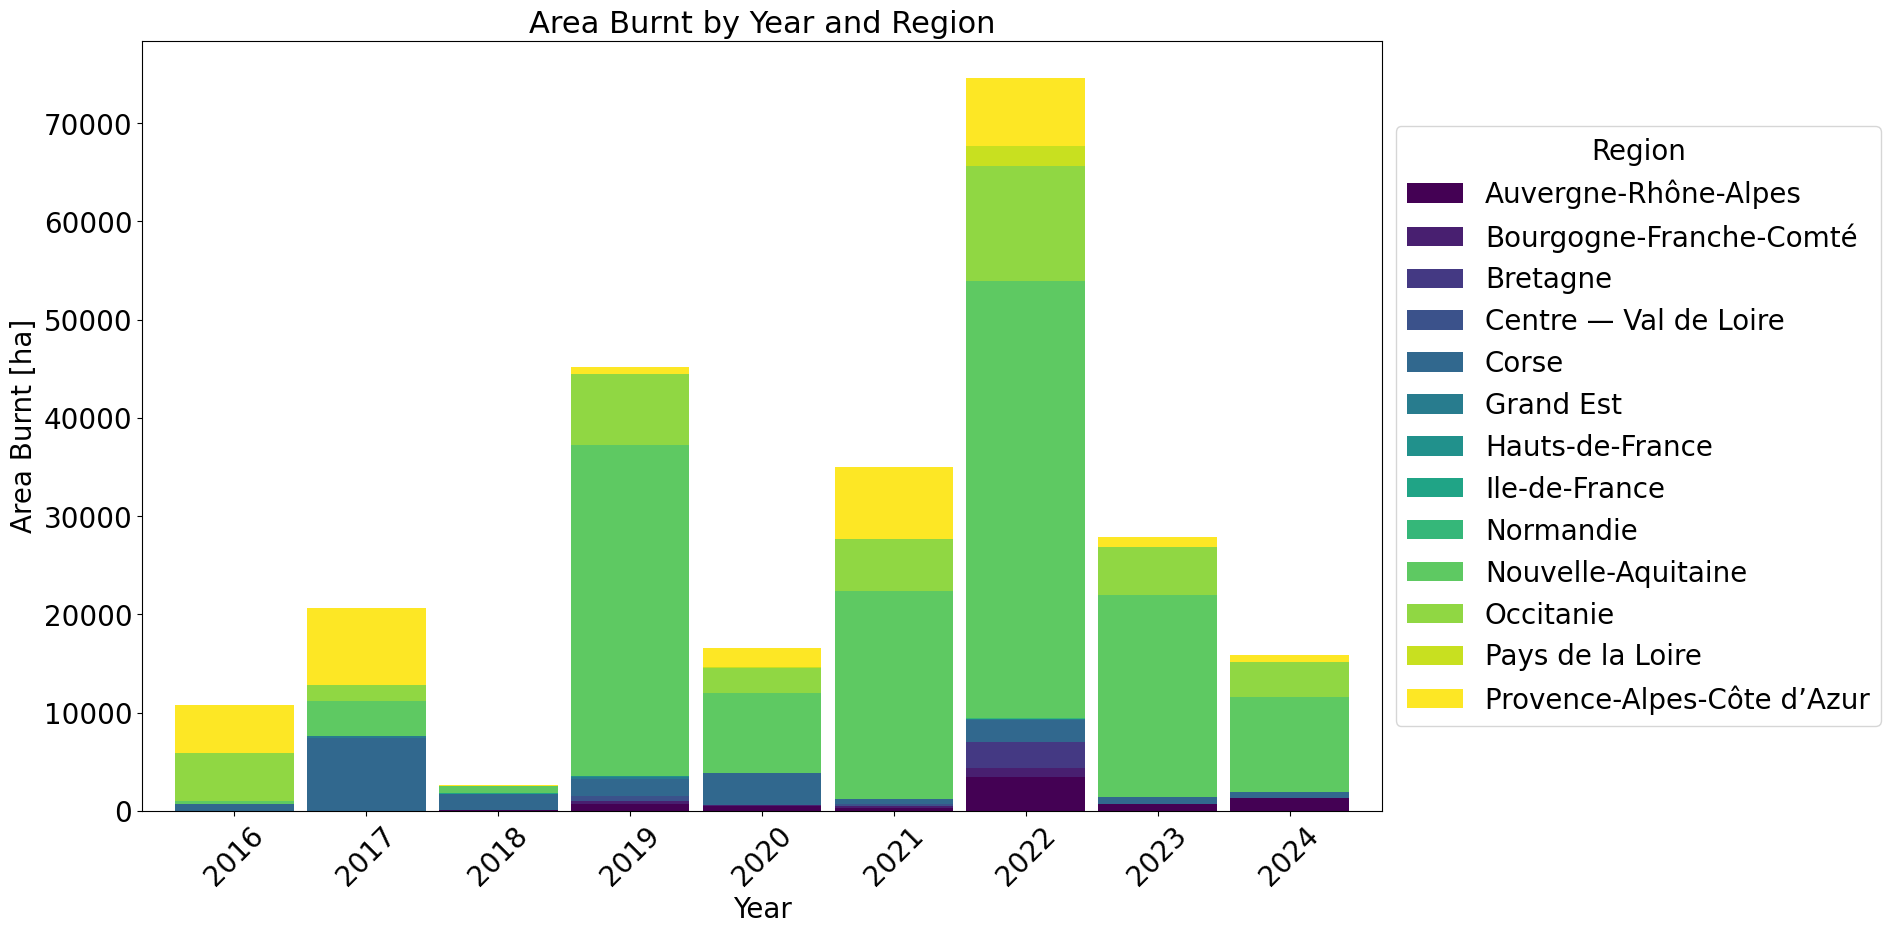

In [572]:
df_pivot = df.pivot_table(values='area_ha', index='year', columns='region', aggfunc='sum', fill_value=0)

df_pivot.plot(kind='bar', stacked=True, colormap='viridis', width=.9)
plt.title('Area Burnt by Year and Region')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Area Burnt [ha]')
plt.legend(title='Region', loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize=med)

### plotting burned area by forest type/ Natura2k region

In [573]:
df_forest = df[['broadleaved_forest_percent','coniferous_forest_percent',
       'mixed_forest_percent', 'sclerophillous_vegetation_percent',
       'transitional_vegetation_percent', 'other_natural_percent',
       'agriculture_percent', 'artificial_percent', 'other_percent']].multiply(df['area_ha']/100, axis="index")

df_forest['year'] = df['year']

In [574]:
forests = ['broadleaved_forest_percent','coniferous_forest_percent',
       'mixed_forest_percent', 'sclerophillous_vegetation_percent',
       'transitional_vegetation_percent', 'other_natural_percent',
       'agriculture_percent', 'artificial_percent', 'other_percent']

df_accumulated = df_forest.groupby('year').sum().reset_index()

new_column_names = [col.replace('_percent', '') for col in df_accumulated.columns]
rename_dict = dict(zip(df_accumulated.columns, new_column_names))
df_accumulated = df_accumulated.rename(columns=rename_dict)

display(df_accumulated)

year  broadleaved_forest  coniferous_forest  mixed_forest  \
0  2016          127.268204         126.900510    124.263852   
1  2017         1292.280766         455.098751    210.132983   
2  2018          664.059509          65.344633     67.764134   
3  2019         8824.833816         753.371834    411.595659   
4  2020         1708.289677        1488.432503   1035.556473   
5  2021         4320.360589         652.863673   1294.387996   
6  2022         4245.958326       20433.957737   3671.709836   
7  2023         3428.143410         230.014153    176.777354   
8  2024         1344.395432          29.537978    145.693101   

   sclerophillous_vegetation  transitional_vegetation  other_natural  \
0                3164.541678               531.801649    4534.317296   
1                2126.151981              1797.146224   13249.767985   
2                 853.297468               151.241252     665.824443   
3                1117.495524             29592.821868    1599.760729   
4                1059.664654               841.311052    9550.529825   
5                5618.211167               887.680979   20394.575589   
6                3323.944200             20179.666814   19002.918347   
7                 816.676370             21094.850749     892.133802   
8                 488.403592             13256.461382     181.277716   

   agriculture  artificial      other  
0  1362.983830  788.216967  32.706013  
1  1125.711814  356.630913  41.078584  
2    65.236037  103.232524   0.000000  
3  2892.965295   25.921233  11.234043  
4   630.077822  264.137994  11.000000  
5  1772.733205   54.186802   0.000000  
6  3293.307975  452.499870  46.036894  
7  1204.612103   25.847105   1.944954  
8   426.382903   10.847894   0.000000

In [575]:
# check if summation amount to the same
display(pd.DataFrame({
    'year': df_accumulated['year'],
    'sum_all_except_year': df_accumulated.drop(columns=['year']).sum(axis=1),
    'area_ha_sum': df.groupby('year')['area_ha'].sum().reset_index()['area_ha']
}))

year  sum_all_except_year  area_ha_sum
0  2016              10793.0        10793
1  2017              20654.0        20654
2  2018               2636.0         2636
3  2019              45230.0        45230
4  2020              16589.0        16589
5  2021              34995.0        34995
6  2022              74650.0        74650
7  2023              27871.0        27871
8  2024              15883.0        15883

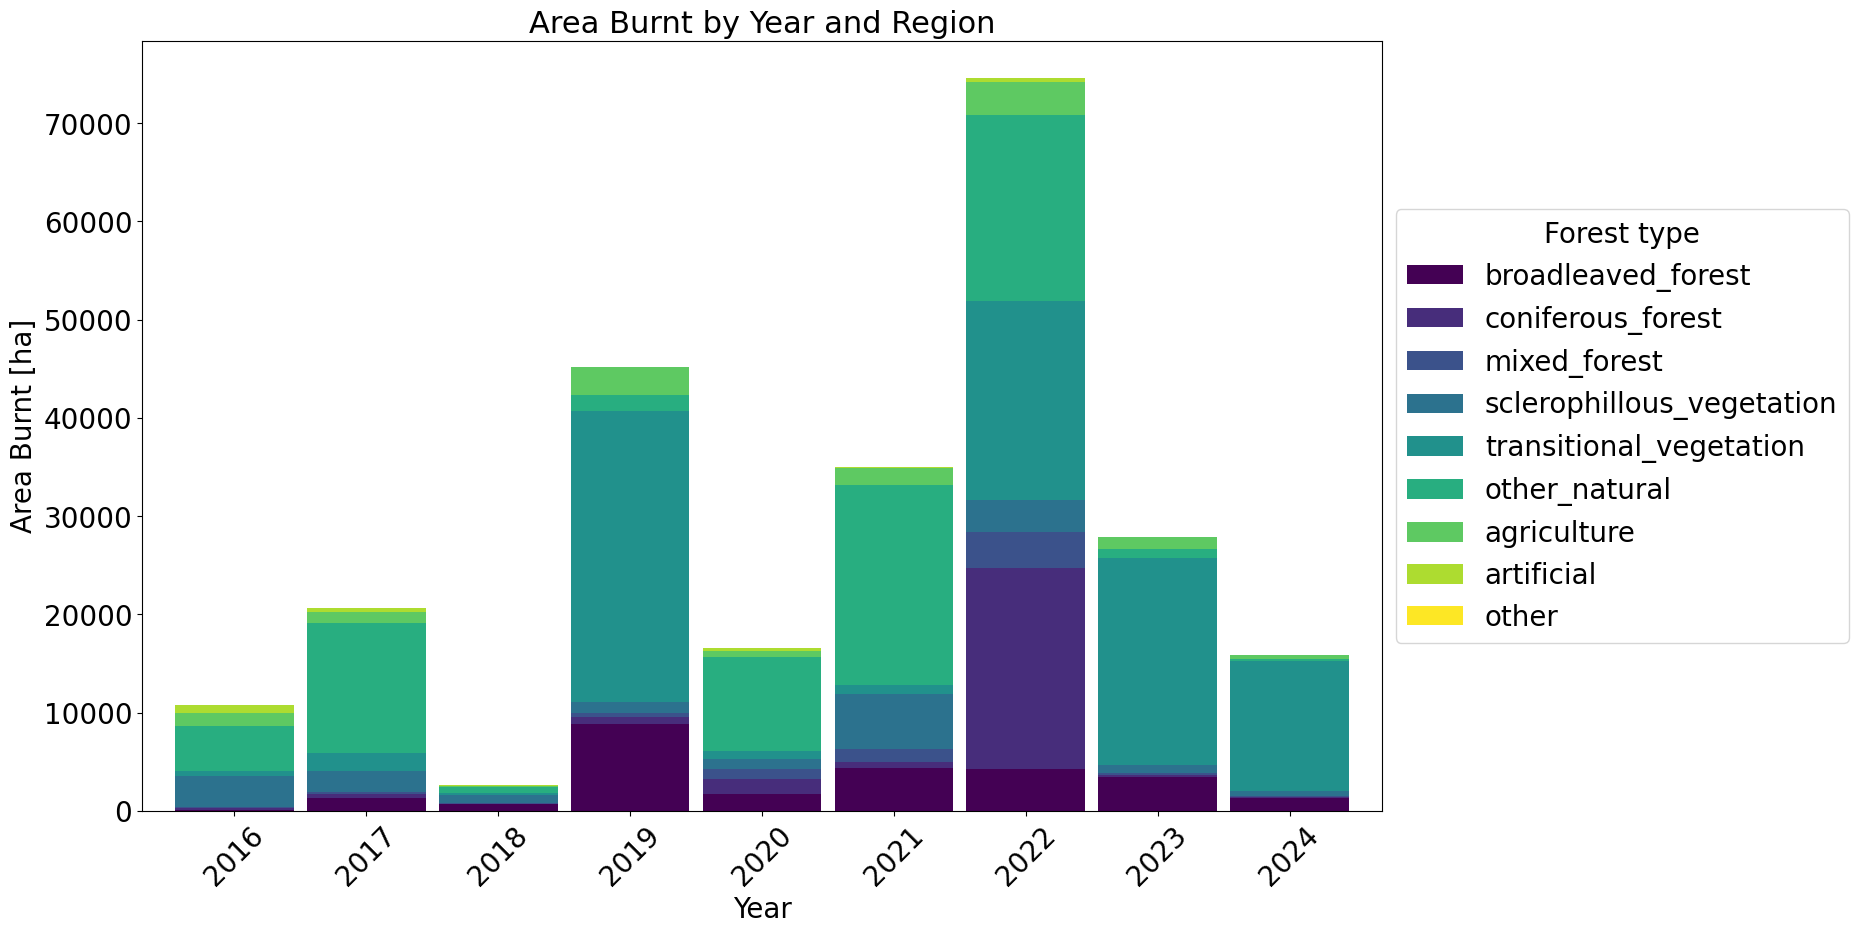

In [576]:
df_accumulated.set_index('year').plot(kind='bar', stacked=True, colormap='viridis', width=.9)
plt.title('Area Burnt by Year and Region')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Area Burnt [ha]')
plt.legend(title='Forest type', loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize=med)

Text(0, 0.5, 'Area Burnt [ha]')

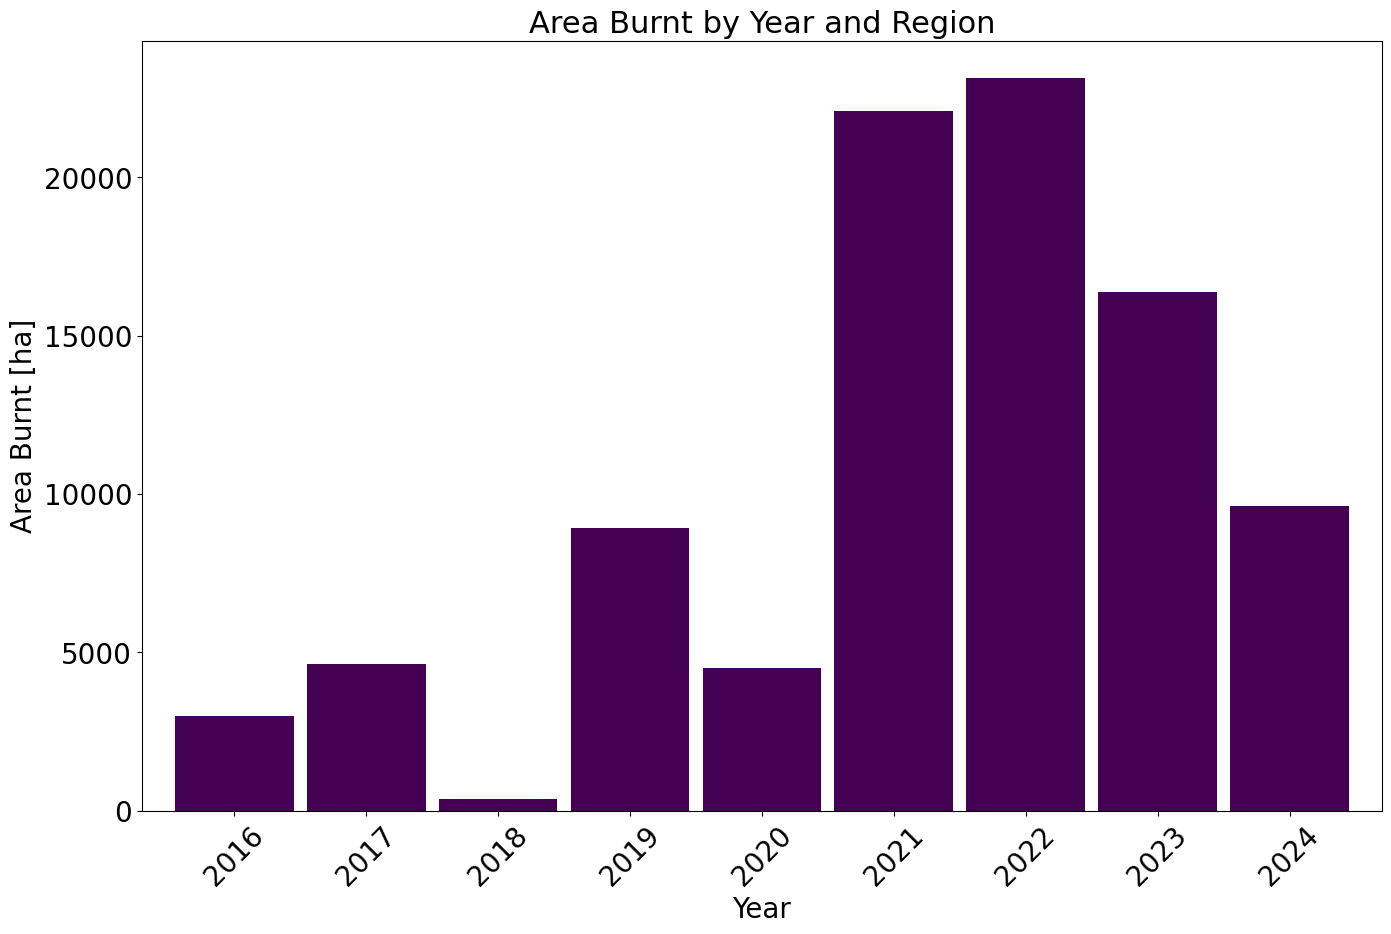

In [577]:
df['Natura2000']=df['natura2k_percent'].multiply(df['area_ha']/100, axis="index")
df_accumulated = df.groupby('year')['Natura2000'].sum().reset_index()
df_accumulated.set_index('year').plot(kind='bar', stacked=True, colormap='viridis', width=.9, legend=False)
plt.title('Area Burnt by Year and Region')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Area Burnt [ha]')

## get communities with latitude and longitude
requested from https://www.data.gouv.fr/en/datasets/communes-de-france-base-des-codes-postaux/

In [578]:
df_geo = pd.read_csv('data/communes-departement-region.csv')
df_geo['code_commune_INSEE'] = df_geo['code_commune_INSEE'].apply('{:0>5}'.format)

In [579]:
# df_geo['code_commune_INSEE'] = pd.to_numeric(df_geo['code_commune_INSEE'], errors='coerce').astype('Int64')
df_geo[df_geo['code_departement'].isnull()]
# df_geo.replace(['2A','2B'],['201','202'], inplace=True)
# df_geo.loc[:,'code_departement']=df_geo['code_departement'].fillna('0')
# df_geo.loc[:,'code_region']=df_geo['code_region'].fillna('0')
# df_geo = df_geo.astype({"code_departement": int, "code_region": int})


code_commune_INSEE nom_commune_postal  code_postal libelle_acheminement  \
39162              98809     L ILE DES PINS        98832                  VAO   
39167              98813             LA FOA        98880               LA FOA   
39174              98817       LE MONT DORE        98809            MONT DORE   
39175              98817       LE MONT DORE        98810            MONT DORE   
39176              98817       LE MONT DORE        98874    PONT DES FRANCAIS   
39177              98817       LE MONT DORE        98875                 PLUM   
39178              98817       LE MONT DORE        98876            LA COULEE   

              ligne_5  latitude  longitude  code_commune article  \
39162  L ILE DES PINS       NaN        NaN           NaN      L'   
39167             NaN       NaN        NaN           NaN      La   
39174             NaN       NaN        NaN           NaN      Le   
39175             NaN       NaN        NaN           NaN      Le   
39176    LE MONT DORE       NaN        NaN           NaN      Le   
39177    LE MONT DORE       NaN        NaN           NaN      Le   
39178    LE MONT DORE       NaN        NaN           NaN      Le   

        nom_commune nom_commune_complet code_departement nom_departement  \
39162  Ile des pins      L'Ile des pins              NaN             NaN   
39167           Foa              La Foa              NaN             NaN   
39174     Mont dore        Le Mont dore              NaN             NaN   
39175     Mont dore        Le Mont dore              NaN             NaN   
39176     Mont dore        Le Mont dore              NaN             NaN   
39177     Mont dore        Le Mont dore              NaN             NaN   
39178     Mont dore        Le Mont dore              NaN             NaN   

       code_region nom_region  
39162          NaN        NaN  
39167          NaN        NaN  
39174          NaN        NaN  
39175          NaN        NaN  
39176          NaN        NaN  
39177          NaN        NaN  
39178          NaN        NaN

In [580]:
df_geo = df_geo.drop(['nom_commune_postal','libelle_acheminement','ligne_5','article','nom_commune_complet', 'code_postal','code_commune', 'code_departement','code_region'], axis=1)
df_geo = df_geo.rename(columns={'nom_commune': 'community', 'nom_departement': 'department', 'nom_region': 'region'})
df_geo.head()

code_commune_INSEE   latitude  longitude              community department  \
0              01001  46.153426   4.926114  Abergement-Clémenciat        Ain   
1              01002  46.009188   5.428017    Abergement-de-Varey        Ain   
2              01004  45.960848   5.372926      Ambérieu-en-Bugey        Ain   
3              01005  45.996180   4.912273    Ambérieux-en-Dombes        Ain   
4              01006  45.749499   5.594320                Ambléon        Ain   

                 region  
0  Auvergne-Rhône-Alpes  
1  Auvergne-Rhône-Alpes  
2  Auvergne-Rhône-Alpes  
3  Auvergne-Rhône-Alpes  
4  Auvergne-Rhône-Alpes

In [581]:
l=len(df_geo)
df_geo = df_geo.dropna(axis=0, how='any')
print(f"dropped NaNs {(l-len(df_geo))/l*100:.2f}%")
l=len(df_geo)
df_geo.drop_duplicates(inplace=True)
print(f"dropped duplicates {(l-len(df_geo))/l*100:.2f}%")

dropped NaNs 0.69%
dropped duplicates 7.73%


In [582]:
population = pd.read_csv('data/population_municipale.csv',delimiter=';', skiprows=2)
l=len(population)
population = population[~population.isin(["N/A - résultat non disponible"]).any(axis=1)]
print(f"dropped {(l-len(population))/l*100:.2f}%")
population.head()

dropped 0.06%


Code                  Libellé Population municipale 2021
0  01001  L'Abergement-Clémenciat                        832
1  01002    L'Abergement-de-Varey                        267
2  01004        Ambérieu-en-Bugey                      14854
3  01005      Ambérieux-en-Dombes                       1897
4  01006                  Ambléon                        113

In [583]:
# population['Code'] = pd.to_numeric(population['Code'], errors='coerce').astype('Int64')
population['Population municipale 2021'] = pd.to_numeric(population['Population municipale 2021'], errors='coerce').astype('Int64')
population.drop(columns='Libellé', axis=0, inplace=True)
population.rename(columns={'Code':'code_commune_INSEE','Population municipale 2021':'population'}, inplace=True)
df_geo = pd.merge(df_geo, population, on=['code_commune_INSEE'])
df_geo.head()


code_commune_INSEE   latitude  longitude              community department  \
0              01001  46.153426   4.926114  Abergement-Clémenciat        Ain   
1              01002  46.009188   5.428017    Abergement-de-Varey        Ain   
2              01004  45.960848   5.372926      Ambérieu-en-Bugey        Ain   
3              01005  45.996180   4.912273    Ambérieux-en-Dombes        Ain   
4              01006  45.749499   5.594320                Ambléon        Ain   

                 region  population  
0  Auvergne-Rhône-Alpes         832  
1  Auvergne-Rhône-Alpes         267  
2  Auvergne-Rhône-Alpes       14854  
3  Auvergne-Rhône-Alpes        1897  
4  Auvergne-Rhône-Alpes         113

Check if Corsica locations are contained (Code commune starts with 2A and 2B)

In [584]:
df_geo[df_geo['code_commune_INSEE'].str.contains('2A|2B')]

code_commune_INSEE   latitude  longitude               community  \
10534              2A001  41.984409   8.798289                     Afa   
10535              2A004  41.934793   8.701323                 Ajaccio   
10536              2A006  41.973519   8.731332                   Alata   
10537              2A008  41.860475   8.877712             Albitreccia   
10538              2A011  41.709198   9.077051                Altagène   
...                  ...        ...        ...                     ...   
10889              2B356  42.253611   9.382163                  Zalana   
10890              2B361  42.518601   8.903763                   Zilia   
10891              2B364  42.264826   9.341266                   Zuani   
10892              2B365  41.971450   9.247756  San-Gavino-di-Fiumorbo   
10893              2B366  41.921009   9.265608                   Chisa   

         department region  population  
10534  Corse-du-Sud  Corse        3336  
10535  Corse-du-Sud  Corse       73822  
10536  Corse-du-Sud  Corse        3587  
10537  Corse-du-Sud  Corse        1775  
10538  Corse-du-Sud  Corse          55  
...             ...    ...         ...  
10889   Haute-Corse  Corse         148  
10890   Haute-Corse  Corse         306  
10891   Haute-Corse  Corse          36  
10892   Haute-Corse  Corse         100  
10893   Haute-Corse  Corse         108  

[360 rows x 7 columns]

In [585]:
df_geo.drop(columns='code_commune_INSEE', inplace=True)

<AxesSubplot:ylabel='Frequency'>

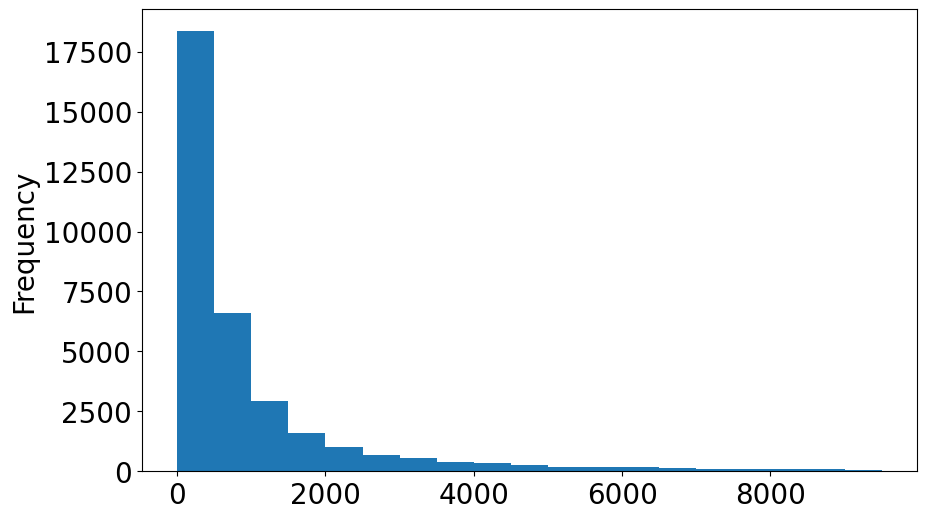

In [586]:
population['population'].plot(kind='hist',bins=np.arange(0,10000,500),figsize=(10,6))

In [587]:
del(population)

## population density
- population municipale from https://statistiques-locales.insee.fr/#c=indicator&i=pop_legales.popmun&s=2021&view=map1
- count population density on a .2deg x .2deg grid to consider distance to infrastructure later

In [588]:
df_geo2 = df_geo[df_geo['latitude']>20]
display(df_geo2)

latitude  longitude              community  department  \
0      46.153426   4.926114  Abergement-Clémenciat         Ain   
1      46.009188   5.428017    Abergement-de-Varey         Ain   
2      45.960848   5.372926      Ambérieu-en-Bugey         Ain   
3      45.996180   4.912273    Ambérieux-en-Dombes         Ain   
4      45.749499   5.594320                Ambléon         Ain   
...          ...        ...                    ...         ...   
34791  49.085900   1.730396     Villers-en-Arthies  Val-d'Oise   
34792  49.070289   2.239509          Villiers-Adam  Val-d'Oise   
34793  49.008449   2.403856        Villiers-le-Bel  Val-d'Oise   
34794  49.074309   2.386890        Villiers-le-Sec  Val-d'Oise   
34795  49.095820   1.825029    Wy-dit-Joli-Village  Val-d'Oise   

                     region  population  
0      Auvergne-Rhône-Alpes         832  
1      Auvergne-Rhône-Alpes         267  
2      Auvergne-Rhône-Alpes       14854  
3      Auvergne-Rhône-Alpes        1897  
4      Auvergne-Rhône-Alpes         113  
...                     ...         ...  
34791         Île-de-France         489  
34792         Île-de-France         852  
34793         Île-de-France       28836  
34794         Île-de-France         196  
34795         Île-de-France         329  

[34796 rows x 6 columns]

In [589]:
# Step 1: Round the latitude and longitude to create grid cells
df_geo2.loc[:,'lat_bin'] = df_geo2.loc[:,'latitude'].multiply(5).round().multiply(.2)  # Group latitude by rounding
df_geo2.loc[:,'lon_bin'] = df_geo2.loc[:,'longitude'].multiply(5).round().multiply(.2)  # Group longitude by rounding

# Step 2: Aggregate population by these grid cells
grid_aggregated = df_geo2.groupby(['lat_bin', 'lon_bin']).agg({
    'population': 'sum'
}).reset_index()

/tmp/ipykernel_2680/1325862432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo2.loc[:,'lat_bin'] = df_geo2.loc[:,'latitude'].multiply(5).round().multiply(.2)  # Group latitude by rounding
/tmp/ipykernel_2680/1325862432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo2.loc[:,'lon_bin'] = df_geo2.loc[:,'longitude'].multiply(5).round().multiply(.2)  # Group longitude by rounding


In [590]:
# Extract x (longitude), y (latitude), and z (population density)
x = grid_aggregated['lon_bin']
y = grid_aggregated['lat_bin']
z = grid_aggregated['population']

# Create a meshgrid
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Pivot the data to create the Z matrix for population density
Z = grid_aggregated.pivot(index='lat_bin', columns='lon_bin', values='population').fillna(0).astype(float).values

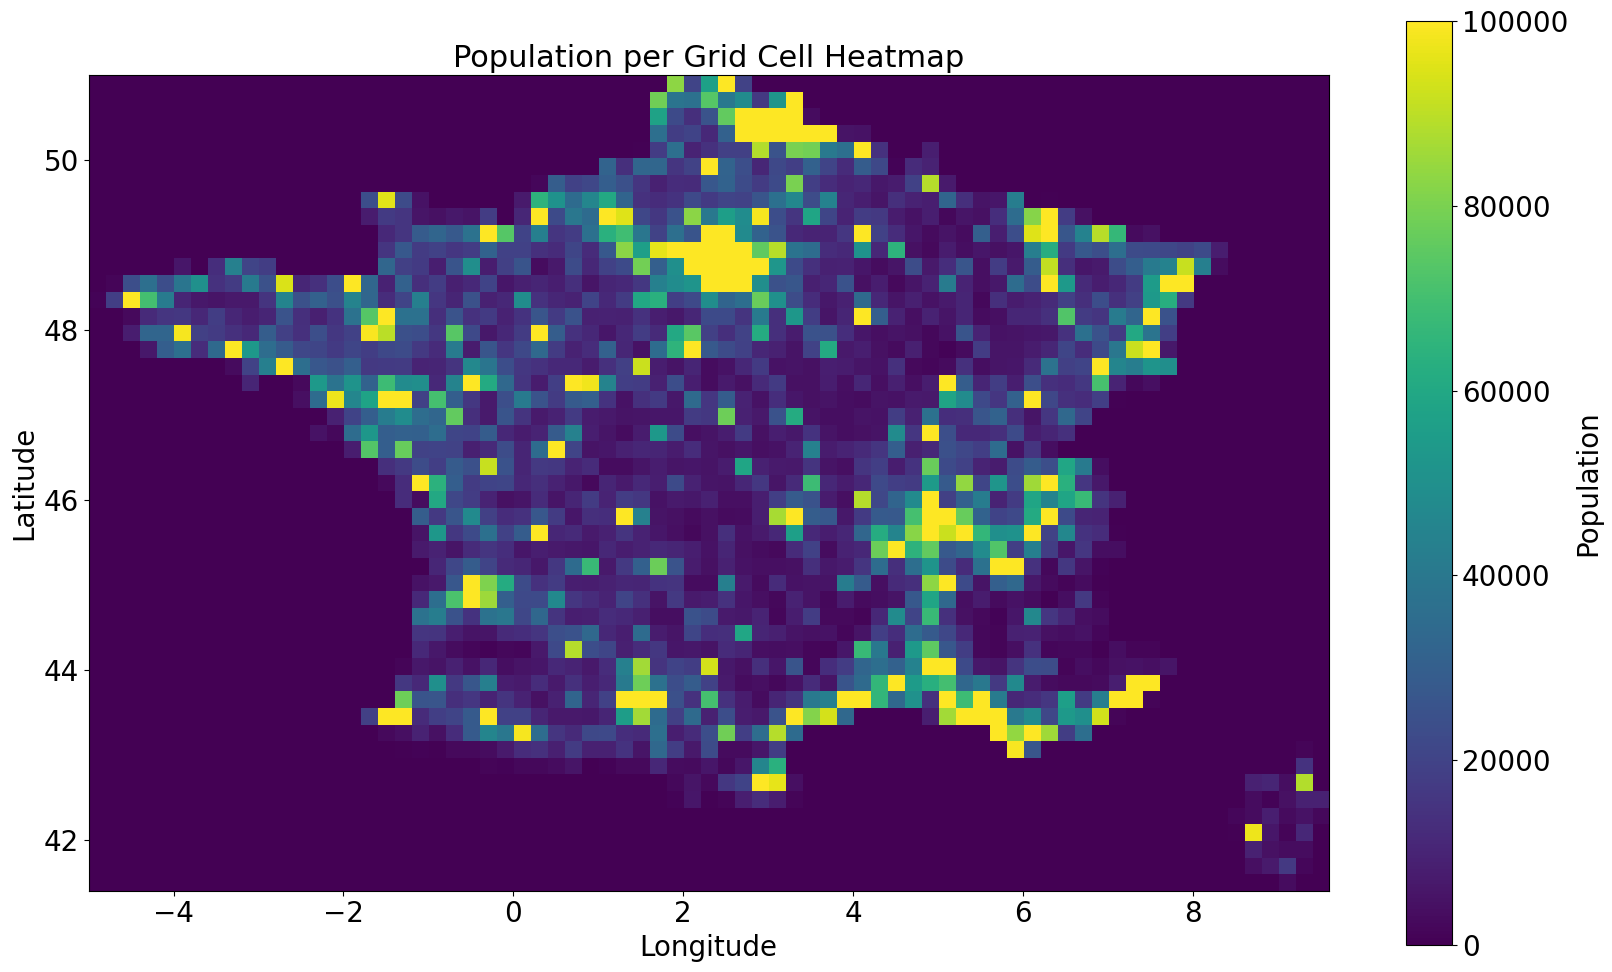

In [591]:
# Step 4: Get the unique latitude and longitude values for the axes
x_labels = grid_aggregated['lon_bin'].unique()
y_labels = grid_aggregated['lat_bin'].unique()

# Step 5: Plot using imshow
plt.figure(figsize=(20, 12))
plt.imshow(Z, cmap='viridis', origin='lower', extent=[x_labels.min(), x_labels.max(), y_labels.min(), y_labels.max()], vmin=0, vmax=1e5)

# Step 6: Add color bar, labels, and title
plt.colorbar(label='Population')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Population per Grid Cell Heatmap')

# Display the plot
plt.show()

## combine communities with fire data

In [159]:
for col in ['community','department','region']:
    df[col] = df[col].str.replace('’', "'", regex=False)
    df[col] = df[col].str.replace('Ile', "Île", regex=False)
    df[col] = df[col].str.replace('Centre — Val', "Centre-Val", regex=False)

In [160]:
df.loc[(df['community'] == 'Arbéost') & (df['region'] == 'Nouvelle-Aquitaine'), 'department'] = 'Hautes-Pyrénées'
df.loc[(df['community'] == 'Arbéost') & (df['region'] == 'Nouvelle-Aquitaine'), 'region'] = 'Occitanie'
df.loc[(df['community'] == 'Cans et Cévennes'), 'community'] = 'Florac Trois Rivières'
df.loc[(df['community'] == 'Bors (Canton de Tude-et-Lavalette)'), 'community'] = 'Bors Canton de Tude-et-Lavalette'
df.loc[(df['community'] == 'Marseille'), 'community'] = 'Marseille 01'

In [161]:
def checking_for_lost_data(df, df_geo):
    not_found = []

    for i, row in df.iterrows():
        community = row['community']
        department = row['department']
        region = row['region']

        # Find matching row in df2
        matching_rows = df_geo[(df_geo['community'] == community) & (df_geo['department'] == department) & (df_geo['region'] == region)]

        if not matching_rows.empty:
            for _, match_row in matching_rows.iterrows():
                if match_row['department'] == department and match_row['region'] == region:
                    # Assign latitude and longitude
                    df.at[i, 'lat'] = match_row['latitude']
                    df.at[i, 'lon'] = match_row['longitude']
                else:
                    print(f"Discrepancy found for '{i}' community '{community}':")
                    print(f"  df -> Department: {department}, Region: {region}")
                    print(f"  df_geo -> Department: {match_row['department']}, Region: {match_row['region']}")
        else:
            # print(f"No match found for community '{community}' in df.")
            not_found.append([community, department, region])
            print(len(not_found))

    #print("\nUpdated df with latitude and longitude:")
    #print(df)
    return not_found

# not_found = checking_for_lost_data(df, df_geo)
# pd.DataFrame(not_found).drop_duplicates()


In [162]:
df_enriched = pd.merge(df, df_geo, on=['community','department','region'], how='left')

In [164]:
df_enriched.drop(['end'], axis=1, inplace=True)

In [166]:
# sns.scatterplot(data=df_enriched, x="lon", y="lat", marker="o", color='k')
# sns.scatterplot(data=df_enriched, x="longitude", y="latitude", hue="region")
# plt.title('test plot')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## gmt plot

In [167]:
df_enriched.columns

Index(['initialdate', 'finaldate', 'area_ha', 'region', 'department',
       'community', 'broadleaved_forest_percent', 'coniferous_forest_percent',
       'mixed_forest_percent', 'sclerophillous_vegetation_percent',
       'transitional_vegetation_percent', 'other_natural_percent',
       'agriculture_percent', 'artificial_percent', 'other_percent',
       'natura2k_percent', 'start', 'year', 'month', 'Natura2000', 'latitude',
       'longitude', 'population'],
      dtype='object')

In [168]:
df_enriched.describe()

area_ha  broadleaved_forest_percent  coniferous_forest_percent  \
count   3660.000000                 3660.000000                3660.000000   
mean      68.115027                   12.463790                   2.414229   
min        0.000000                    0.000000                   0.000000   
25%        8.000000                    0.000000                   0.000000   
50%       21.000000                    0.000000                   0.000000   
75%       50.000000                   14.726595                   0.000000   
max    13116.000000                  100.000000                 100.000000   
std      330.770552                   23.209459                  12.722429   

       mixed_forest_percent  sclerophillous_vegetation_percent  \
count           3660.000000                         3660.00000   
mean               1.984231                            3.48290   
min                0.000000                            0.00000   
25%                0.000000                            0.00000   
50%                0.000000                            0.00000   
75%                0.000000                            0.00000   
max              100.000000                          100.00000   
std               11.358395                           16.80997   

       transitional_vegetation_percent  other_natural_percent  \
count                      3660.000000            3660.000000   
mean                         45.552973              28.782347   
min                           0.000000               0.000000   
25%                           0.000000               0.000000   
50%                          45.700246               0.000000   
75%                          95.087699              76.005848   
max                         100.000000             100.000000   
std                          44.573883              41.373935   

       agriculture_percent  artificial_percent  other_percent  \
count          3660.000000         3660.000000    3660.000000   
mean              4.834595            0.442219       0.042718   
min               0.000000            0.000000       0.000000   
25%               0.000000            0.000000       0.000000   
50%               0.000000            0.000000       0.000000   
75%               0.000000            0.000000       0.000000   
max             100.000000          100.000000     100.000000   
std              14.757279            5.390097       1.728965   

       natura2k_percent                          start         year  \
count       3660.000000                           3660  3660.000000   
mean          43.366699  2021-11-30 20:35:35.068058880  2021.678962   
min            0.000000            2016-03-26 00:00:00  2016.000000   
25%            0.000000            2021-03-02 12:18:00  2021.000000   
50%            3.839684            2022-02-10 12:53:00  2022.000000   
75%          100.000000            2023-02-18 16:21:00  2023.000000   
max          100.000000            2024-06-12 01:58:00  2024.000000   
std           47.927296                            NaN     1.741711   

             month   Natura2000     latitude    longitude   population  
count  3660.000000  3660.000000  3642.000000  3642.000000       3642.0  
mean      3.312842    25.303966    43.513099     1.704387  1209.500824  
min       1.000000     0.000000    41.435499    -3.950109          5.0  
25%       2.000000     0.000000    43.009815    -0.950546        156.0  
50%       2.000000     1.507826    43.128960     0.023519        264.0  
75%       3.000000    18.000000    44.087553     3.769180        635.0  
max      12.000000  3975.665726    49.847735     9.511957      57082.0  
std       2.497487   114.682149     0.988651     3.196801  4547.942204

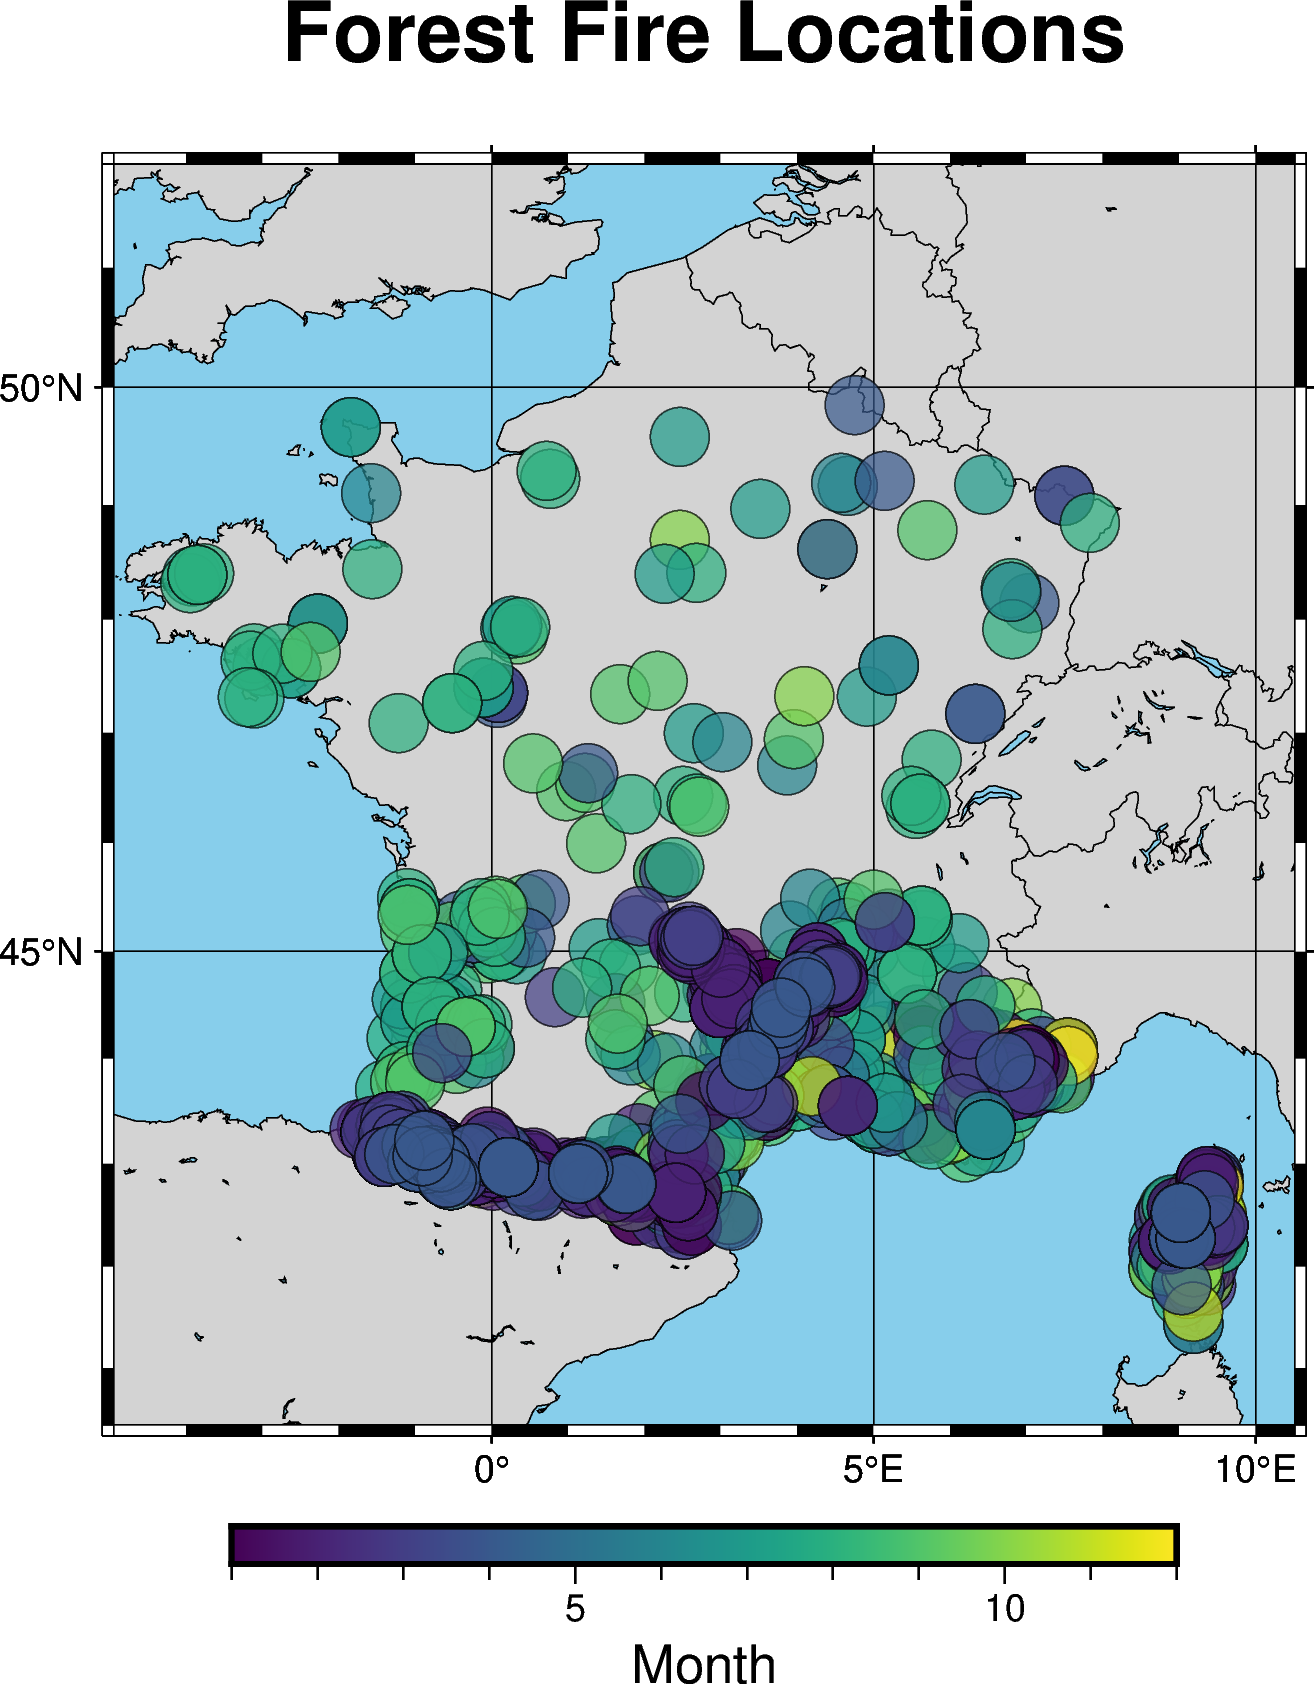

In [375]:
fig = pygmt.Figure()

# Define the region (longitude and latitude bounds)
region = [df_enriched['longitude'].min() - 1, df_enriched['longitude'].max() + 1, df_enriched['latitude'].min() - 1, df_enriched['latitude'].max() + 2]

# Create the basemap
# fig.basemap(region=region, projection="M10c", frame=True)
fig.basemap(region=region, projection="M10c", frame=True)

# Add coastlines for context
fig.coast(shorelines=True, borders=[1, 2], water="skyblue", land="lightgray", frame=["xafg+lLongitude",
        "yafg+lLatitude",
        "WSen+tForest Fire Locations"])

# Create a color palette based on the year
# pygmt.makecpt(cmap="viridis", series=[df['year'].min(), df['year'].max()])
pygmt.makecpt(cmap="viridis", series=[df['month'].min(), df['month'].max()])

fig.plot(x=df_enriched['longitude'], y=df_enriched['latitude'], style="c0.5c", pen="black", 
        size=df_enriched['area_ha']/100000,  # Adjust the size for visibility
        fill=df_enriched['month'], cmap=True,
        transparency=30)

fig.colorbar(frame='af+l"Month"')

fig.show()


## get weather for the past 14days per data point

In [172]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [173]:
def get_weather(lat,lon,start,end):
	# Make sure all required weather variables are listed here
	# The order of variables in hourly or daily is important to assign them correctly below
	# The order of variables in hourly or daily is important to assign them correctly below
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": lat,
		"longitude": lon,
		"start_date": start,
		"end_date": end,
		"daily": ["temperature_2m_max", "temperature_2m_min", "daylight_duration", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]
	}
	responses = openmeteo.weather_api(url, params=params)

	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	# print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
	# print(f"Elevation {response.Elevation()} m asl")
	# print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
	# print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
	daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
	daily_daylight_duration = daily.Variables(2).ValuesAsNumpy()
	daily_precipitation_sum = daily.Variables(3).ValuesAsNumpy()
	daily_wind_speed_10m_max = daily.Variables(4).ValuesAsNumpy()
	daily_wind_direction_10m_dominant = daily.Variables(5).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
		start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
		end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = daily.Interval()),
		inclusive = "left"
	)}
	daily_data["temperature_2m_max"] = daily_temperature_2m_max
	daily_data["temperature_2m_min"] = daily_temperature_2m_min
	daily_data["daylight_duration"] = daily_daylight_duration
	daily_data["precipitation_sum"] = daily_precipitation_sum
	daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
	daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant

	return pd.DataFrame(data = daily_data)

In [174]:
df_enriched['initialdate']=(df_enriched.start - pd.Timedelta(days=14)).dt.strftime('%Y-%m-%d')
df_enriched['finaldate']=df_enriched.start.dt.strftime('%Y-%m-%d')

In [175]:
length = df_enriched.shape[0]

In [181]:
cols = ["temperature_2m_max", "temperature_2m_min", "daylight_duration", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]

if if_weather:

    for i, row in df_enriched.iterrows():
        print(f"getting {i} of {length}...")
        lat,lon,s,e = row[['latitude','longitude','initialdate','finaldate']]
        weather = get_weather(lat, lon, s, e)
        for col in cols:
            df_enriched.at[i, col] = weather[col].mean()
        time.sleep(3) # to avoid time out of API

In [427]:
df_enriched[['start', 'area_ha', 'temperature_2m_max', 'temperature_2m_min',
       'daylight_duration', 'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant']].head()

start  area_ha  temperature_2m_max  temperature_2m_min  \
0 2016-06-19       50           23.265503           15.845500   
1 2016-07-14      745           29.952833           19.346165   
2 2016-07-13      383           29.633501           18.676832   
3 2016-08-10       95           31.493498           20.966831   
4 2016-07-18      599           31.104164           17.194166   

   daylight_duration  precipitation_sum  wind_speed_10m_max  \
0       54896.566406           1.053333           15.989712   
1       54797.640625           0.226667           20.886568   
2       54919.722656           0.346667           23.337831   
3       52040.699219           0.600000           25.444996   
4       54628.003906           0.033333           18.111027   

   wind_direction_10m_dominant  
0                   267.038025  
1                   281.446381  
2                   278.566376  
3                   301.190247  
4                   248.454300

### saving data

In [182]:
if if_weather:

    with open('data/weather.pickle', 'wb') as handle:
        pickle.dump(df_enriched, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [183]:
if if_weather:
    df = df_enriched

## getting zero data for random communities

In [593]:
with open('data/weather.pickle', 'rb') as handle:
    df = pickle.load(handle)

Text(0, 0.5, 'latitude')

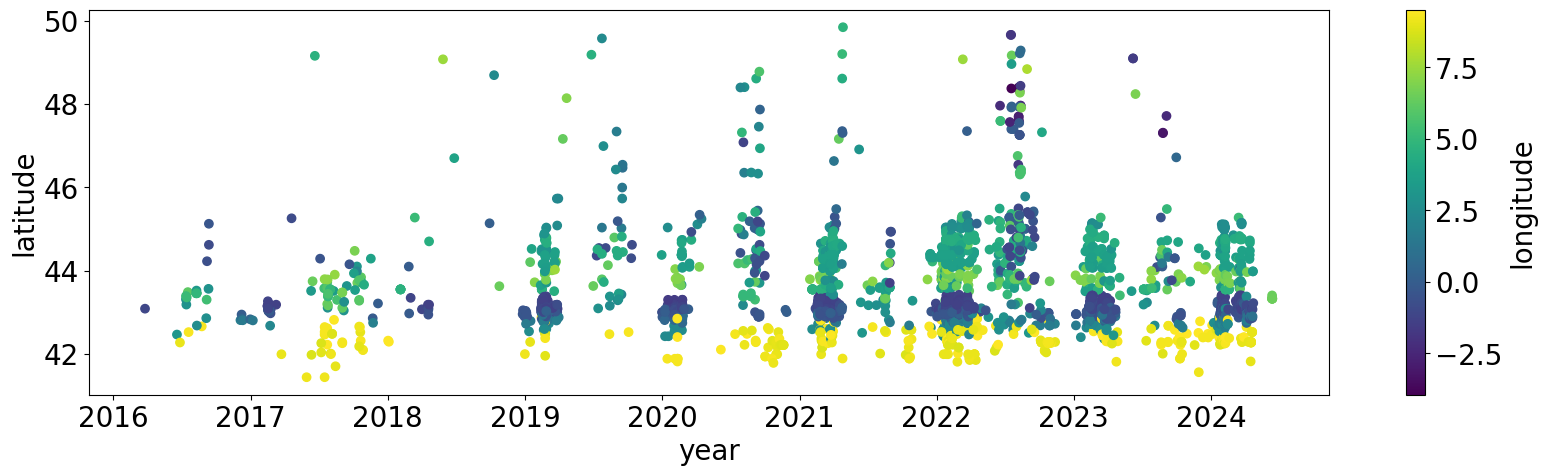

In [395]:
plt.figure(figsize=(20,5))
plt.scatter(df.start, df.latitude, c=df.longitude)
plt.colorbar(label='longitude')
plt.xlabel('year')
plt.ylabel('latitude')

In [186]:
df = df.sort_values(by='start')
df['dtime'] = df['start'].diff()
print(df['dtime'].mean(), df['dtime'].min(), df['dtime'].max())

0 days 19:10:29.848202396 0 days 00:00:00 94 days 00:00:00


As the average time difference between data points is about 24hrs, a time lag for zero points of 1day would be okay. But it would generate too much data.

In [187]:
unique_cols = ['community', 'department', 'region']
df_unique = df.drop_duplicates(subset = unique_cols)
print(f"Percentage of communities without recorded forest fires is {len(df_unique)/ len(df_geo)*100:.2f}%.")

Percentage of communities without recorded forest fires is 2.69%.


There are much more communities without fire, than with recorded forest fire.

In [188]:
df_geo.columns

Index(['latitude', 'longitude', 'community', 'department', 'region',
       'population'],
      dtype='object')

In [189]:
# The reference date for when to start calculating non-fire periods
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2024-06-30')
community_diff = 23
random_places = 200

unique_geo = df_geo[['community', 'department', 'region', 'latitude', 'longitude']].drop_duplicates(subset=['community','department','region'])


In [190]:
def addvalues(results, community, department, region, latitude, longitude, current_date):
    results.append({
                'community': community,
                'department': department,
                'region': region,
                'latitude': latitude,
                'longitude': longitude,
                'fire_date': current_date,
                'fire_status': 'fire'
            })
    return results

results = []

random_communities = unique_geo.sample(n=random_places, random_state=42)

# Iterate over the unique combinations
# for i, row in unique_geo.iloc[::community_diff].iterrows():
for i, row in random_communities.iterrows():
    community, department, region, latitude, longitude = row['community'], row['department'], row['region'], row['latitude'], row['longitude']
    # Get the fire dates for the specific community
    community_fires = df[(df['community'] == community) & (df['department'] == department) & (df['region'] == region)].sort_values(by='start')

    # If there are no fires recorded since 2015, take the whole period since 2015
    if community_fires.empty:
        # print('made-up fires in', community)
        current_date = start_date + pd.DateOffset(days=random.uniform(21,90))
        while (current_date <= end_date):
            results = addvalues(results, community, department, region, latitude, longitude, current_date)
            # print('made-uo fire in', community, 'at', current_date)
            current_date += pd.DateOffset(days=random.uniform(21,180))

    else:
        current_date = start_date + pd.DateOffset(days=random.uniform(21,90))
    #     print('fires in', community)
        # Add the period from 2015 to the first fire date (if there's a gap)
        if community_fires.iloc[0]['start'] > current_date:
            results = addvalues(results, community, department, region, latitude, longitude, current_date)

        # Add periods between fires
        for i in range(1, len(community_fires)):
            if community_fires.iloc[i]['start'] - community_fires.iloc[i-1]['start'] > pd.to_timedelta("90 days"):
                current_date += pd.DateOffset(days=random.uniform(21,90))
                results = addvalues(results, community, department, region, latitude, longitude, current_date)

        # Add the period from the last fire date to now (if there's a gap)
        if community_fires.iloc[-1]['start'] < end_date - pd.to_timedelta("90 days"):
            current_date += pd.DateOffset(days=random.uniform(21,90))
            results = addvalues(results, community, department, region, latitude, longitude, current_date)

# Convert the results list to a DataFrame
df_no_fires = pd.DataFrame(results)


In [191]:
df_no_fires = df_no_fires[df_no_fires['latitude'] > 40]

In [192]:
print(f"ratio between fire data and non-fire data: {len(df)/len(df_no_fires):.2f}")

ratio between fire data and non-fire data: 0.56


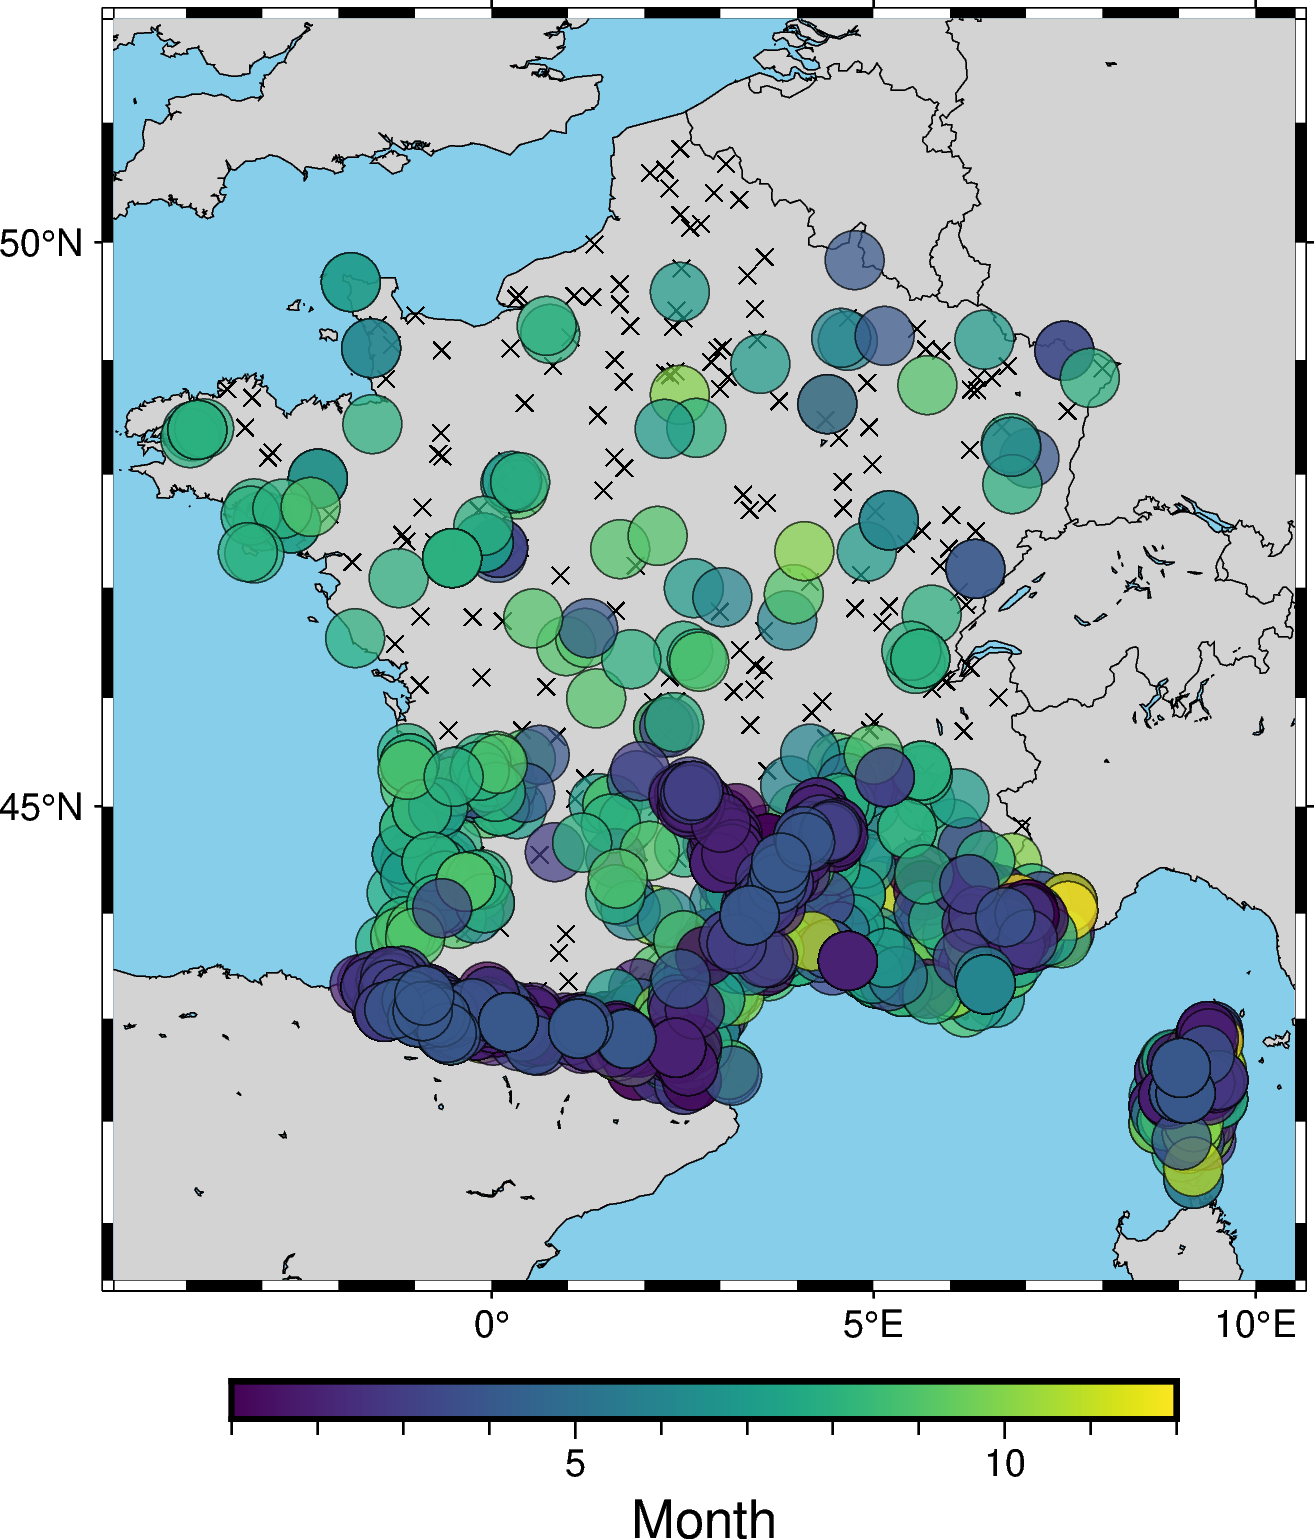

In [206]:
fig = pygmt.Figure()

# Define the region (longitude and latitude bounds)
region = [df['longitude'].min() - 1, df['longitude'].max() + 1, df['latitude'].min() - 1, df['latitude'].max() + 2]

# Create the basemap
fig.basemap(region=region, projection="M10c", frame=True)

# Add coastlines for context
fig.coast(shorelines=True, borders=[1, 2], water="skyblue", land="lightgray")

# Create a color palette based on the year
# pygmt.makecpt(cmap="viridis", series=[df['year'].min(), df['year'].max()])
pygmt.makecpt(cmap="viridis", series=[df['month'].min(), df['month'].max()])

fig.plot(x=df_no_fires['longitude'], y=df_no_fires['latitude'], style="x0.2c", pen="black", 
            fill="red", transparency=50)

# Plot the points with size proportional to area burnt
fig.plot(x=df['longitude'], y=df['latitude'], style="c0.5c", pen="black", 
            size=df['area_ha']/100000,  # Adjust the size for visibility
            fill=df['month'], cmap=True,
            transparency=30)



fig.colorbar(frame='af+l"Month"')

fig.show()


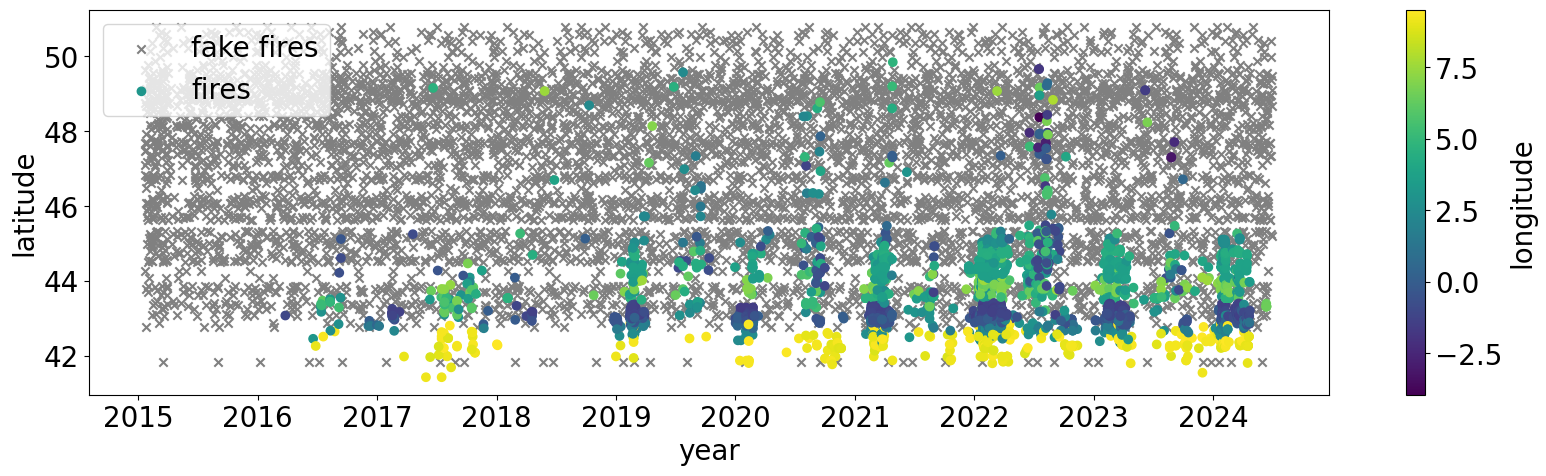

In [394]:
plt.figure(figsize=(20,5))
# sns.kdeplot(
#     x=df_no_fires['fire_date'].apply(lambda x: x.timestamp()),  # Convert dates to timestamps for continuous kde
#     y=df_no_fires['latitude'],
#     cmap="Reds",
#     fill=True,
#     bw_adjust=0.5,  # Adjust bandwidth to control the smoothness
#     alpha=0.5,  # Transparency of the density map
# )
plt.scatter(df_no_fires.fire_date, df_no_fires.latitude, c='grey', label='fake fires', marker='x')
plt.scatter(df.start, df.latitude, c=df.longitude,label='fires')
plt.colorbar(label='longitude')
plt.xlabel('year')
plt.ylabel('latitude')
plt.legend(loc='upper left')
# plt.ylim((41,51))

## fill up dataframe & get weather for non-fire places

In [195]:
df.columns

Index(['initialdate', 'finaldate', 'area_ha', 'region', 'department',
       'community', 'broadleaved_forest_percent', 'coniferous_forest_percent',
       'mixed_forest_percent', 'sclerophillous_vegetation_percent',
       'transitional_vegetation_percent', 'other_natural_percent',
       'agriculture_percent', 'artificial_percent', 'other_percent',
       'natura2k_percent', 'start', 'year', 'month', 'latitude', 'longitude',
       'temperature_2m_max', 'temperature_2m_min', 'daylight_duration',
       'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'dtime'],
      dtype='object')

In [196]:
new_columns = ['broadleaved_forest_percent', 'coniferous_forest_percent',
       'mixed_forest_percent', 'sclerophillous_vegetation_percent',
       'transitional_vegetation_percent', 'other_natural_percent',
       'agriculture_percent', 'artificial_percent', 'other_percent',
       'natura2k_percent']

for col in new_columns:
    df_no_fires[col] = df['longitude'].fillna(0)

# df_no_fires.drop(columns={'fire_status'})

In [197]:
df_no_fires.columns

Index(['community', 'department', 'region', 'latitude', 'longitude',
       'fire_date', 'fire_status', 'broadleaved_forest_percent',
       'coniferous_forest_percent', 'mixed_forest_percent',
       'sclerophillous_vegetation_percent', 'transitional_vegetation_percent',
       'other_natural_percent', 'agriculture_percent', 'artificial_percent',
       'other_percent', 'natura2k_percent'],
      dtype='object')

In [198]:
df_no_fires['initialdate']=(df_no_fires.fire_date - pd.Timedelta(days=14)).dt.strftime('%Y-%m-%d')
df_no_fires['finaldate']=df_no_fires.fire_date.dt.strftime('%Y-%m-%d')

In [199]:
length = df_no_fires.shape[0]

In [200]:
cols = ["temperature_2m_max", "temperature_2m_min", "daylight_duration", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]

if if_weather:

    for i, row in df_no_fires.iterrows():
        print(f"getting {i} of {length}...")
        lat,lon,s,e = row[['latitude','longitude','initialdate','finaldate']]
        weather = get_weather(lat, lon, s, e)
        for col in cols:
            df_no_fires.at[i, col] = weather[col].mean()
        time.sleep(3) # to avoid time out of API

In [201]:
df_no_fires.columns

Index(['community', 'department', 'region', 'latitude', 'longitude',
       'fire_date', 'fire_status', 'broadleaved_forest_percent',
       'coniferous_forest_percent', 'mixed_forest_percent',
       'sclerophillous_vegetation_percent', 'transitional_vegetation_percent',
       'other_natural_percent', 'agriculture_percent', 'artificial_percent',
       'other_percent', 'natura2k_percent', 'initialdate', 'finaldate'],
      dtype='object')

In [202]:
if if_weather:

    forest_data_cols = ['broadleaved_forest_percent',
       'coniferous_forest_percent', 'mixed_forest_percent',
       'sclerophillous_vegetation_percent', 'transitional_vegetation_percent',
       'other_natural_percent', 'agriculture_percent', 'artificial_percent',
       'other_percent', 'natura2k_percent']
    for col in forest_data_cols:
        df_no_fires[col]=0

    with open('data/weather_nofires.pickle', 'wb') as handle:
        pickle.dump(df_no_fires, handle, protocol=pickle.HIGHEST_PROTOCOL)

## load and merge dataset

In [594]:
!ls data/ -lt

total 22452
-rw-rw-r-- 1 oceanblue oceanblue 2417579 Oct  6 08:56 complete_dataset.pickle
-rw-rw-r-- 1 oceanblue oceanblue  812565 Oct  4 19:23 population_municipale.csv
-rw-rw-r-- 1 oceanblue oceanblue 1411072 Oct  2 08:58 weather_nofires.pickle
-rw-rw-r-- 1 oceanblue oceanblue 4333759 Sep  4 00:35 Monthly_Burned_area_1980_2020_EUROPE_v1.csv
-rw-rw-r-- 1 oceanblue oceanblue  791473 Aug 26 19:01 weather.pickle
-rw-r--r-- 1 oceanblue oceanblue 7299813 Aug 25 21:10 c88835a3458448da9ff6dfc2e1d8eee4.csv
-rw-rw-r-- 1 oceanblue oceanblue    3332 Aug 25 18:42 departements-france.csv
-rw-rw-r-- 1 oceanblue oceanblue 5067889 Aug 25 18:41 communes-departement-region.csv
-rw-r--r-- 1 oceanblue oceanblue  831363 Aug 25 17:55 1ad52b0980f34045b1cc16faf61103eb.csv


In [391]:
with open('data/weather.pickle', 'rb') as handle:
    df = pickle.load(handle)
with open('data/weather_nofires.pickle', 'rb') as handle:
    df_no_fires = pickle.load(handle)

In [207]:
df_no_fires

community      department            region   latitude  \
0     Saint-Georges-sur-Loire  Maine-et-Loire  Pays de la Loire  47.402468   
1     Saint-Georges-sur-Loire  Maine-et-Loire  Pays de la Loire  47.402468   
2     Saint-Georges-sur-Loire  Maine-et-Loire  Pays de la Loire  47.402468   
3     Saint-Georges-sur-Loire  Maine-et-Loire  Pays de la Loire  47.402468   
4     Saint-Georges-sur-Loire  Maine-et-Loire  Pays de la Loire  47.402468   
...                       ...             ...               ...        ...   
6935                Labruyère            Oise   Hauts-de-France  49.352727   
6936                Labruyère            Oise   Hauts-de-France  49.352727   
6937                Labruyère            Oise   Hauts-de-France  49.352727   
6938                Labruyère            Oise   Hauts-de-France  49.352727   
6939                Labruyère            Oise   Hauts-de-France  49.352727   

      longitude  fire_date fire_status  broadleaved_forest_percent  \
0     -0.756078 2015-03-01        fire                           0   
1     -0.756078 2015-04-30        fire                           0   
2     -0.756078 2015-05-26        fire                           0   
3     -0.756078 2015-08-12        fire                           0   
4     -0.756078 2016-01-18        fire                           0   
...         ...        ...         ...                         ...   
6935   2.507696 2023-04-24        fire                           0   
6936   2.507696 2023-05-15        fire                           0   
6937   2.507696 2023-10-08        fire                           0   
6938   2.507696 2023-12-07        fire                           0   
6939   2.507696 2024-05-24        fire                           0   

      coniferous_forest_percent  mixed_forest_percent  ...  other_percent  \
0                             0                     0  ...              0   
1                             0                     0  ...              0   
2                             0                     0  ...              0   
3                             0                     0  ...              0   
4                             0                     0  ...              0   
...                         ...                   ...  ...            ...   
6935                          0                     0  ...              0   
6936                          0                     0  ...              0   
6937                          0                     0  ...              0   
6938                          0                     0  ...              0   
6939                          0                     0  ...              0   

      natura2k_percent  initialdate   finaldate  temperature_2m_max  \
0                    0   2015-02-15  2015-03-01            9.618667   
1                    0   2015-04-16  2015-04-30           17.655333   
2                    0   2015-05-12  2015-05-26           17.441998   
3                    0   2015-07-29  2015-08-12           25.931999   
4                    0   2016-01-04  2016-01-18            8.608667   
...                ...          ...         ...                 ...   
6935                 0   2023-04-10  2023-04-24           12.677166   
6936                 0   2023-05-01  2023-05-15           17.133831   
6937                 0   2023-09-24  2023-10-08           21.747166   
6938                 0   2023-11-23  2023-12-07            6.837167   
6939                 0   2024-05-10  2024-05-24           19.263832   

      temperature_2m_min  daylight_duration precipitation_sum  \
0               3.148667       38395.753906          2.766666   
1               8.818666       50527.050781          1.873333   
2               8.525333       54900.152344          0.313333   
3              14.768666       53150.527344          0.493333   
4               4.012000       31536.064453          2.773333   
...                  ...                ...               ...   
6935     

In [208]:
df['fire'] = 1

In [209]:
df.describe()

area_ha  broadleaved_forest_percent  coniferous_forest_percent  \
count   3756.000000                 3756.000000                3756.000000   
mean      69.606763                   12.194044                   2.422043   
min        0.000000                    0.000000                   0.000000   
25%        8.000000                    0.000000                   0.000000   
50%       22.000000                    0.000000                   0.000000   
75%       50.000000                   14.285714                   0.000000   
max    13116.000000                  100.000000                 100.000000   
std      340.560870                   23.036434                  12.706844   

       mixed_forest_percent  sclerophillous_vegetation_percent  \
count           3756.000000                        3756.000000   
mean               1.938977                           3.497923   
min                0.000000                           0.000000   
25%                0.000000                           0.000000   
50%                0.000000                           0.000000   
75%                0.000000                           0.000000   
max              100.000000                         100.000000   
std               11.218409                          16.799716   

       transitional_vegetation_percent  other_natural_percent  \
count                      3756.000000            3756.000000   
mean                         45.532972              29.149138   
min                           0.000000               0.000000   
25%                           0.000000               0.000000   
50%                          45.227273               0.000000   
75%                          95.238095              77.777778   
max                         100.000000             100.000000   
std                          44.660391              41.616994   

       agriculture_percent  artificial_percent  other_percent  ...  \
count          3756.000000         3756.000000    3756.000000  ...   
mean              4.786068            0.437145       0.041690  ...   
min               0.000000            0.000000       0.000000  ...   
25%               0.000000            0.000000       0.000000  ...   
50%               0.000000            0.000000       0.000000  ...   
75%               0.000000            0.000000       0.000000  ...   
max             100.000000          100.000000     100.000000  ...   
std              14.636231            5.326155       1.706736  ...   

             month     latitude    longitude  temperature_2m_max  \
count  3756.000000  3756.000000  3756.000000         3756.000000   
mean      3.315495    43.518818     1.772715           13.199601   
min       1.000000    41.435499    -3.950109           -2.829667   
25%       2.000000    43.009815    -0.903673            9.020125   
50%       2.000000    43.131830     0.059762           11.706249   
75%       3.000000    44.087553     3.769180           15.154834   
max      12.000000    49.847735     9.511957           35.763332   
std       2.494689     0.987621     3.196135            6.708679   

       temperature_2m_min  daylight_duration  precipitation_sum  \
count         3756.000000        3756.000000        3756.000000   
mean             3.972116       40374.778464           1.836255   
min            -12.729667       31874.945312           0.000000   
25%              0.000375       36068.339844           0.240000   
50%              2.748000       38671.837891           0.980000   
75%              6.059209       43544.765625           2.715000   
max             25.799000       58373.148438          21.326666   
std              6.012868        5831.981620           2.256908   

       wind_speed_10m_max  wind_direction_10m_dominant    fire  
count         3756.000000                  3756.000000  3756.0  
mean            15.064736                   191.698142     1.0  
min              4.712916                    38.413925     1.0  
25%             11.0

In [210]:
df_no_fires['area_ha']=0
df_no_fires['fire']=0
df_no_fires['year'] = pd.to_datetime(df_no_fires['initialdate']).dt.year
df_no_fires['month'] = pd.to_datetime(df_no_fires['initialdate']).dt.month
df_no_fires.drop(columns={'fire_status'}, inplace=True)
df_no_fires.rename(columns={'fire_date':'start'}, inplace=True)
# df.drop(columns={'start'}, inplace=True)

In [211]:
missing_in_df_no_fires = [col for col in df if col not in df_no_fires]
missing_in_df = [col for col in df_no_fires if col not in df]

In [212]:
print(missing_in_df, missing_in_df_no_fires)

[] []


In [213]:
df_no_fires.describe()

latitude    longitude                          start  \
count  6905.000000  6905.000000                           6905   
mean     46.998734     2.631566  2019-10-03 13:00:34.931209472   
min      41.840436    -3.461598            2015-01-22 00:00:00   
25%      45.317836     0.627800            2017-05-21 00:00:00   
50%      47.344081     2.469921            2019-10-03 00:00:00   
75%      48.833116     4.808605            2022-02-14 00:00:00   
max      50.780730     9.068852            2024-06-30 00:00:00   
std       2.090535     2.591032                            NaN   

       broadleaved_forest_percent  coniferous_forest_percent  \
count                      6905.0                     6905.0   
mean                          0.0                        0.0   
min                           0.0                        0.0   
25%                           0.0                        0.0   
50%                           0.0                        0.0   
75%                           0.0                        0.0   
max                           0.0                        0.0   
std                           0.0                        0.0   

       mixed_forest_percent  sclerophillous_vegetation_percent  \
count                6905.0                             6905.0   
mean                    0.0                                0.0   
min                     0.0                                0.0   
25%                     0.0                                0.0   
50%                     0.0                                0.0   
75%                     0.0                                0.0   
max                     0.0                                0.0   
std                     0.0                                0.0   

       transitional_vegetation_percent  other_natural_percent  \
count                           6905.0                 6905.0   
mean                               0.0                    0.0   
min                                0.0                    0.0   
25%                                0.0                    0.0   
50%                                0.0                    0.0   
75%                                0.0                    0.0   
max                                0.0                    0.0   
std                                0.0                    0.0   

       agriculture_percent  ...  temperature_2m_max  temperature_2m_min  \
count               6905.0  ...         6905.000000         6905.000000   
mean                   0.0  ...           16.044493            7.858220   
min                    0.0  ...           -3.256166          -11.434999   
25%                    0.0  ...           10.274833            3.366667   
50%                    0.0  ...           15.518167            7.519000   
75%                    0.0  ...           21.844667           12.817000   
max                    0.0  ...           35.154499           22.355999   
std                    0.0  ...            7.029050            5.593802   

       daylight_duration  precipitation_sum  wind_speed_10m_max  \
count        6905.000000        6905.000000         6905.000000   
mean        44083.862588           2.515924           18.081564   
min         28666.841797           0.000000            5.025621   
25%         35425.625000           1.020000           15.081199   
50%         44169.722656           2.113333           17.728855   
75%         52990.546875           3.560000           20.742714   
max         59313.195312          17.920000           41.340725   
std          9138.938509           1.977385            4.599483   

       wind_direction_10m_dominant  area_ha    fire         year        month  
count                  6905.000000   6905.0  6905.0  6905.000000  6905.000000  
mean                    191.800576      0.0     0.0  2019.231716     6.345402  
min                      18.949240      0.0     0.0  2015.000000     1.000000  
25%                     161.415024      0.0     0.0  2017

In [214]:
cols_df = df.columns
df_no_fires = df_no_fires[cols_df]

In [215]:
df_combined = pd.concat([df, df_no_fires], ignore_index=True)

In [16]:
# sns.scatterplot(data=df, x='temperature_2m_max', y='precipitation_sum', hue='area_ha')

## gridding

41.5 51.0 -4.0 9.5


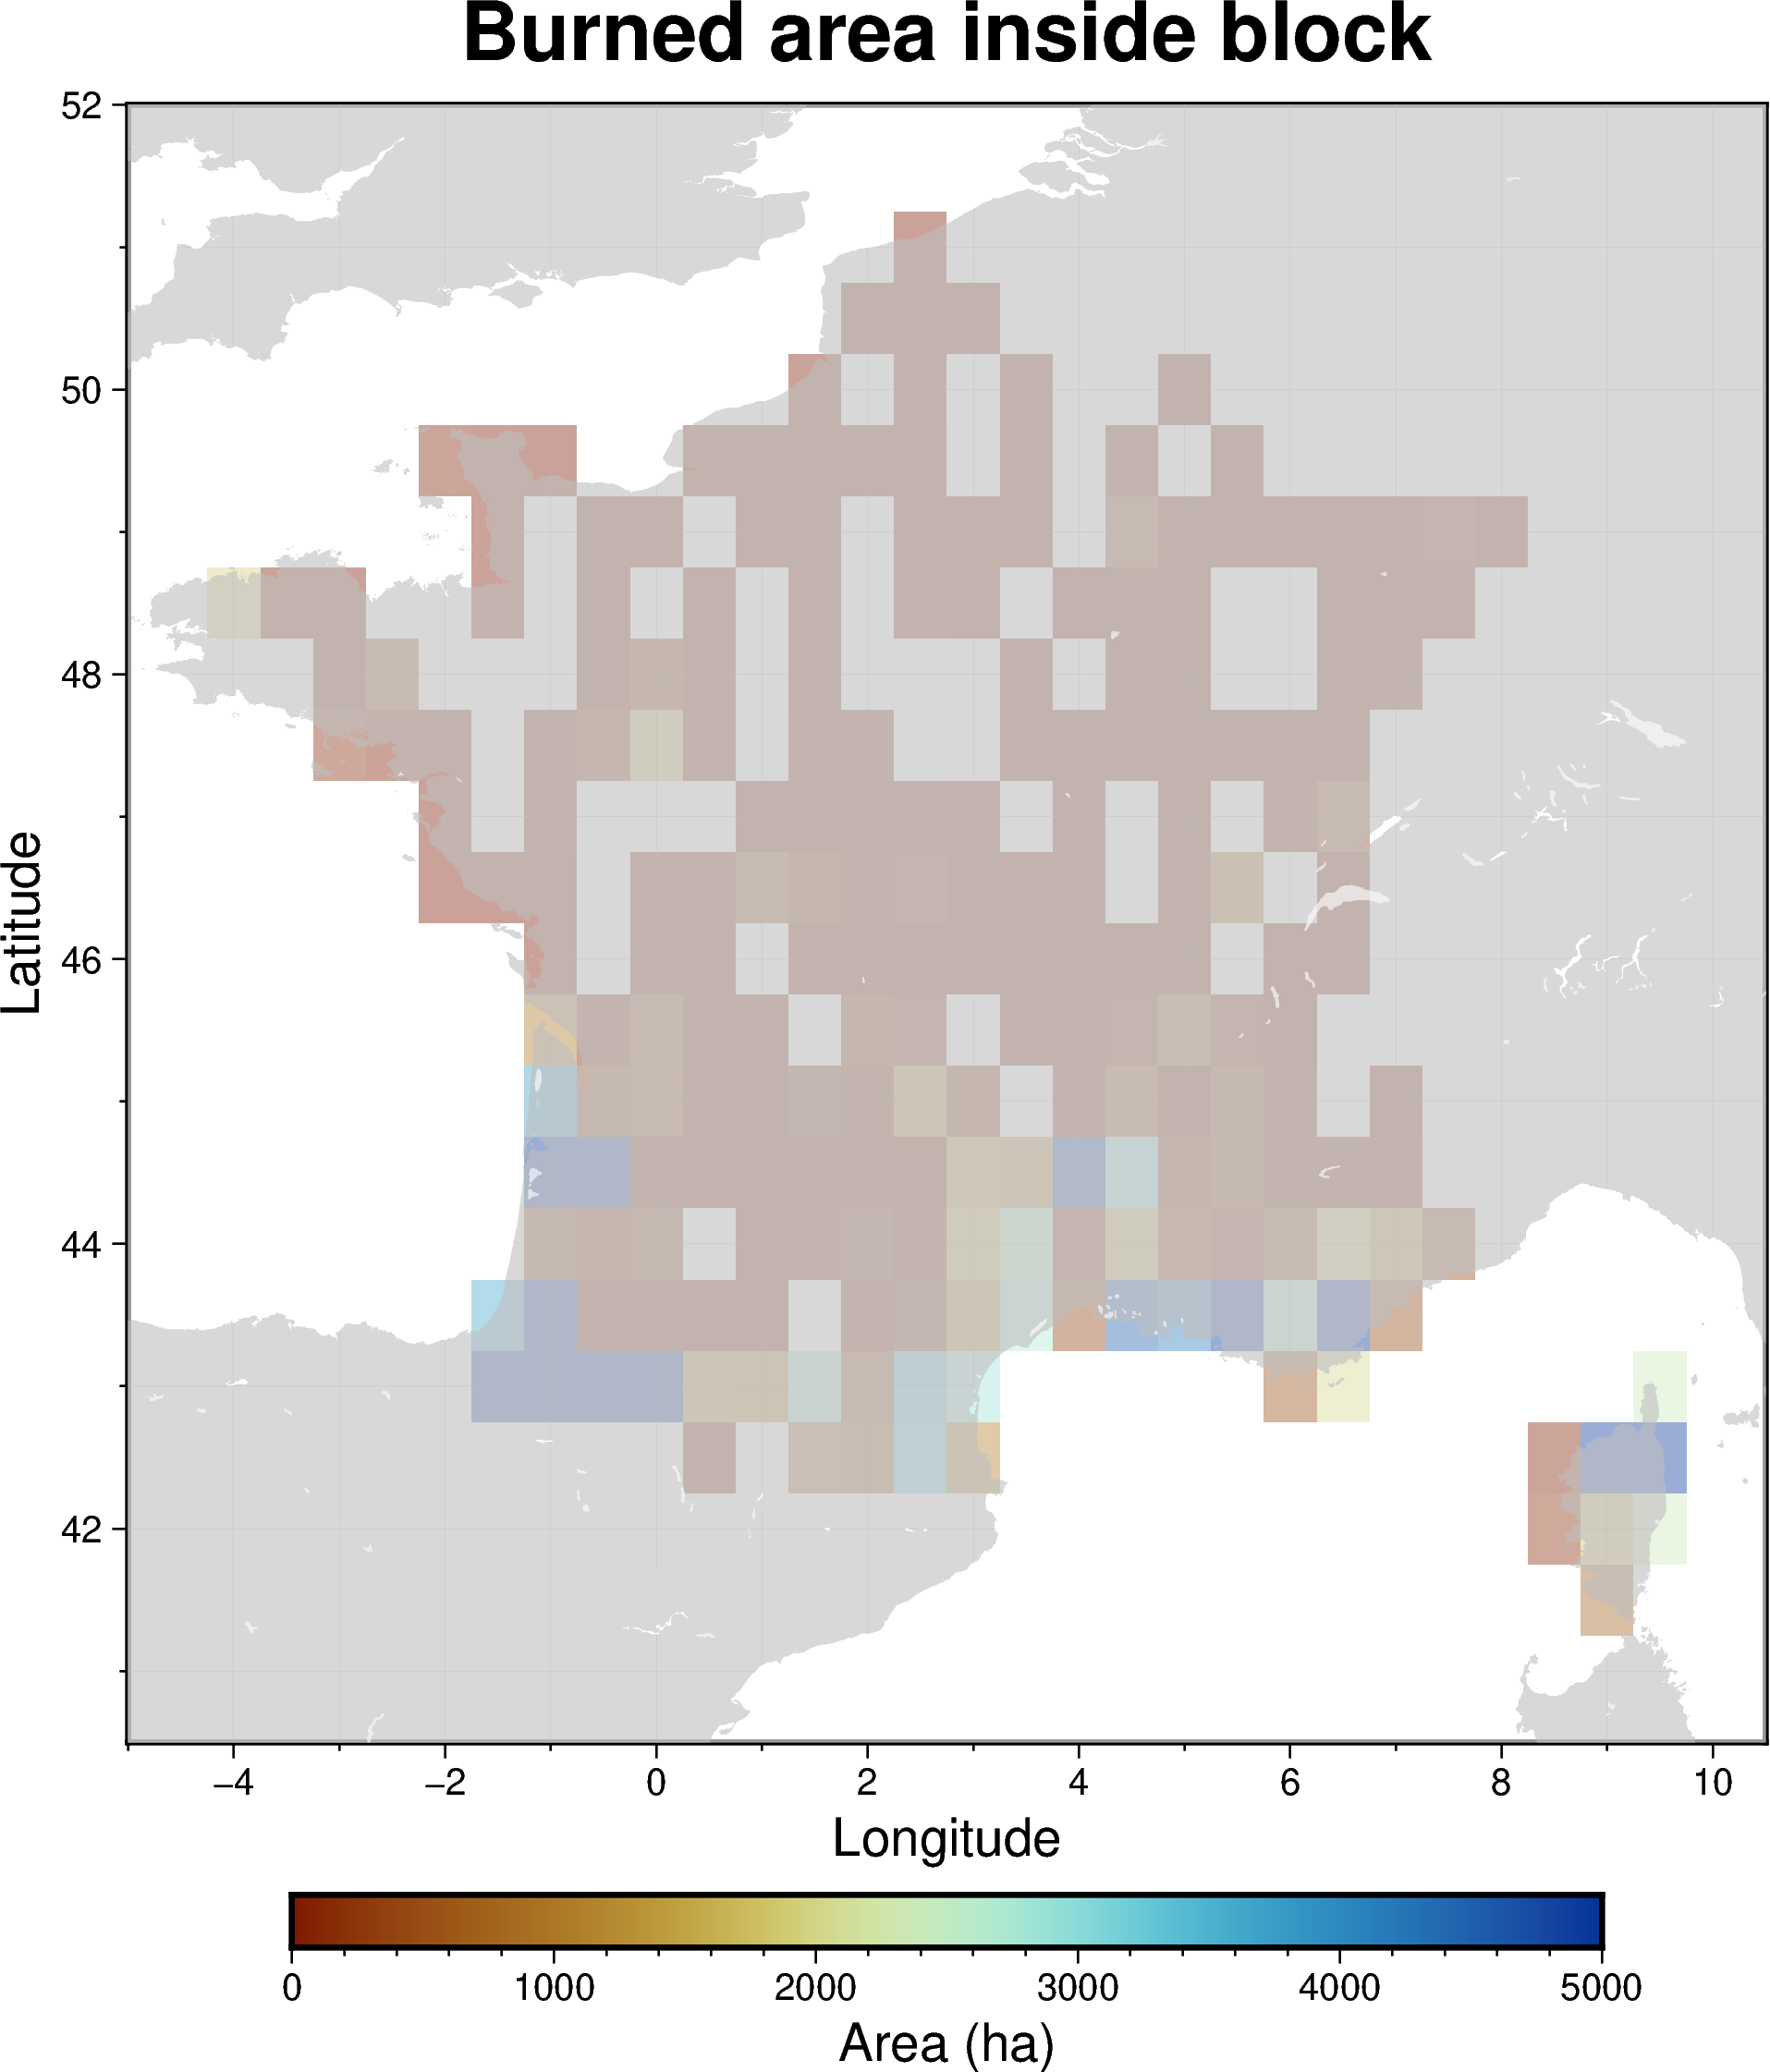

In [431]:
gridfunction(df_combined, 'latitude', 'longitude', 'area_ha', 'Burned area inside block', 'Area (ha)', spacing=".5", colmap='roma', vmax=5000)

## introducing neighboring fires

In [129]:
from geopy.distance import geodesic

def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

In [158]:
from scipy.spatial import cKDTree

# Step 1: Create a new neighbor column initialized to False
df_combined['neighbor'] = False
l = len(df_combined)

# Step 2: Pre-process the data by creating a KD-Tree for spatial queries
coordinates = np.array(list(zip(df_combined['latitude'], df_combined['longitude'])))
tree = cKDTree(coordinates)

# Step 3: Iterate over the fire events
for i, row in df_combined.iterrows():
    
    # Step 3.1: Get all points within a 10km radius using the KD-Tree
    idx = tree.query_ball_point([row['latitude'], row['longitude']], r=10/6371)  # Normalize by Earth's radius
    
    # Step 3.2: Iterate through the indices of nearby points
    for j in idx:
        if i != j:  # Avoid self-comparison
            other_row = df_combined.iloc[j]
            
            # Step 3.3: Calculate the time difference in days
            time_diff = abs((row['start'] - other_row['start']).days)
            
            # Step 3.4: Check if the time difference is <= 3 days
            if time_diff <= 3:
                df_combined.at[i, 'neighbor'] = True
                break  # No need to check further once a neighbor is found


In [418]:
from scipy.spatial import cKDTree

# Step 1: Filter the DataFrame to include only rows where fire == 1
df_fire = df_combined[df_combined['fire'] == 1].copy()

# Step 2: Initialize the 'neighbor' column to False in the filtered DataFrame
df_fire['neighbor'] = False
l = len(df_fire)

# Step 3: Pre-process the data by creating a KD-Tree for spatial queries
coordinates = np.array(list(zip(df_fire['latitude'], df_fire['longitude'])))
tree = cKDTree(coordinates)

# Step 4: Iterate over the fire events in the filtered DataFrame
for i, row in df_fire.iterrows():
    
    # Step 4.1: Get all points within a 10 km radius using the KD-Tree
    idx = tree.query_ball_point([row['latitude'], row['longitude']], r=10/6371)  # Normalize by Earth's radius
    
    # Step 4.2: Iterate through the indices of nearby points
    for j in idx:
        if i != j:  # Avoid self-comparison
            other_row = df_fire.iloc[j]
            
            # Step 4.3: Calculate the time difference in days
            time_diff = (row['start'] - other_row['start']).days
            
            # Step 4.4: Check if the time difference is <= 3 days
            if time_diff <= 3 and time_diff > 0:
                df_fire.at[i, 'neighbor'] = True
                break  # No need to check further once a neighbor is found

# Step 5: Merge the 'neighbor' results back into the original DataFrame
df_combined['neighbor']=False
df_combined.update(df_fire[['neighbor']])


In [422]:
print(df_combined['neighbor'].value_counts())

neighbor
False    10075
True       583
Name: count, dtype: int64


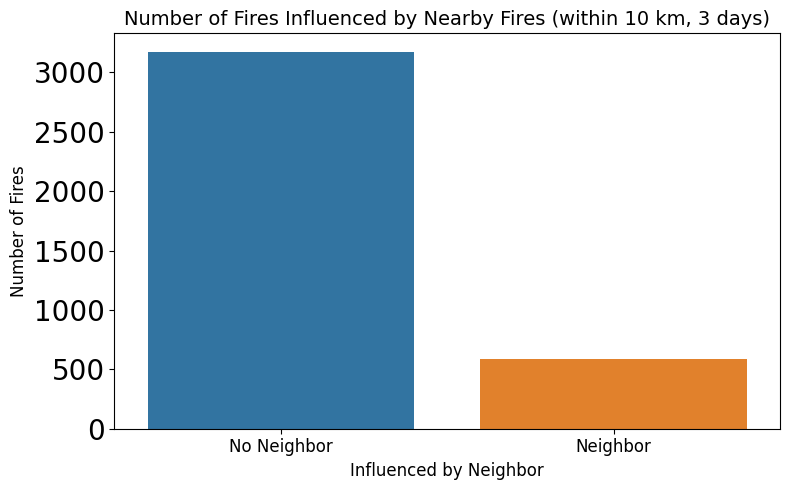

In [420]:
# Step 1: Count the number of fires influenced by neighbors
neighbor_counts = df_fire['neighbor'].value_counts()

# Step 2: Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=neighbor_counts.index, y=neighbor_counts.values, hue=neighbor_counts.index, legend=False)

# Step 3: Add labels and title
plt.xticks([0, 1], ['No Neighbor', 'Neighbor'], fontsize=12)
plt.ylabel('Number of Fires', fontsize=12)
plt.xlabel('Influenced by Neighbor', fontsize=12)
plt.title('Number of Fires Influenced by Nearby Fires (within 10 km, 3 days)', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

## obtain population density within grid cell
cheaper to be done here, since I added this information after I downloaded the weather data

In [296]:
df_combined['lat_bin'] = df_combined['latitude'].multiply(5).round().multiply(.2)  # Create bins for latitude
df_combined['lon_bin'] = df_combined['longitude'].multiply(5).round().multiply(.2)  # Create bins for longitude

In [222]:
df_combined = df_combined.merge(grid_aggregated, on=['lat_bin', 'lon_bin'])

In [305]:
with open('data/complete_dataset.pickle', 'wb') as handle:
        pickle.dump(df_combined, handle, protocol=pickle.HIGHEST_PROTOCOL)

# EDA
- data ranges and distributions
- scatterplots per target
- normalization vs standardization
- outliers (boxplots) and analysis
- multikolinearitaet

In [302]:
with open('data/weather.pickle', 'rb') as handle:
    df = pickle.load(handle)
with open('data/complete_dataset.pickle', 'rb') as handle:
    df_combined = pickle.load(handle)

## histograms

In [328]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=numerics)

1. first exploration of all columns of df

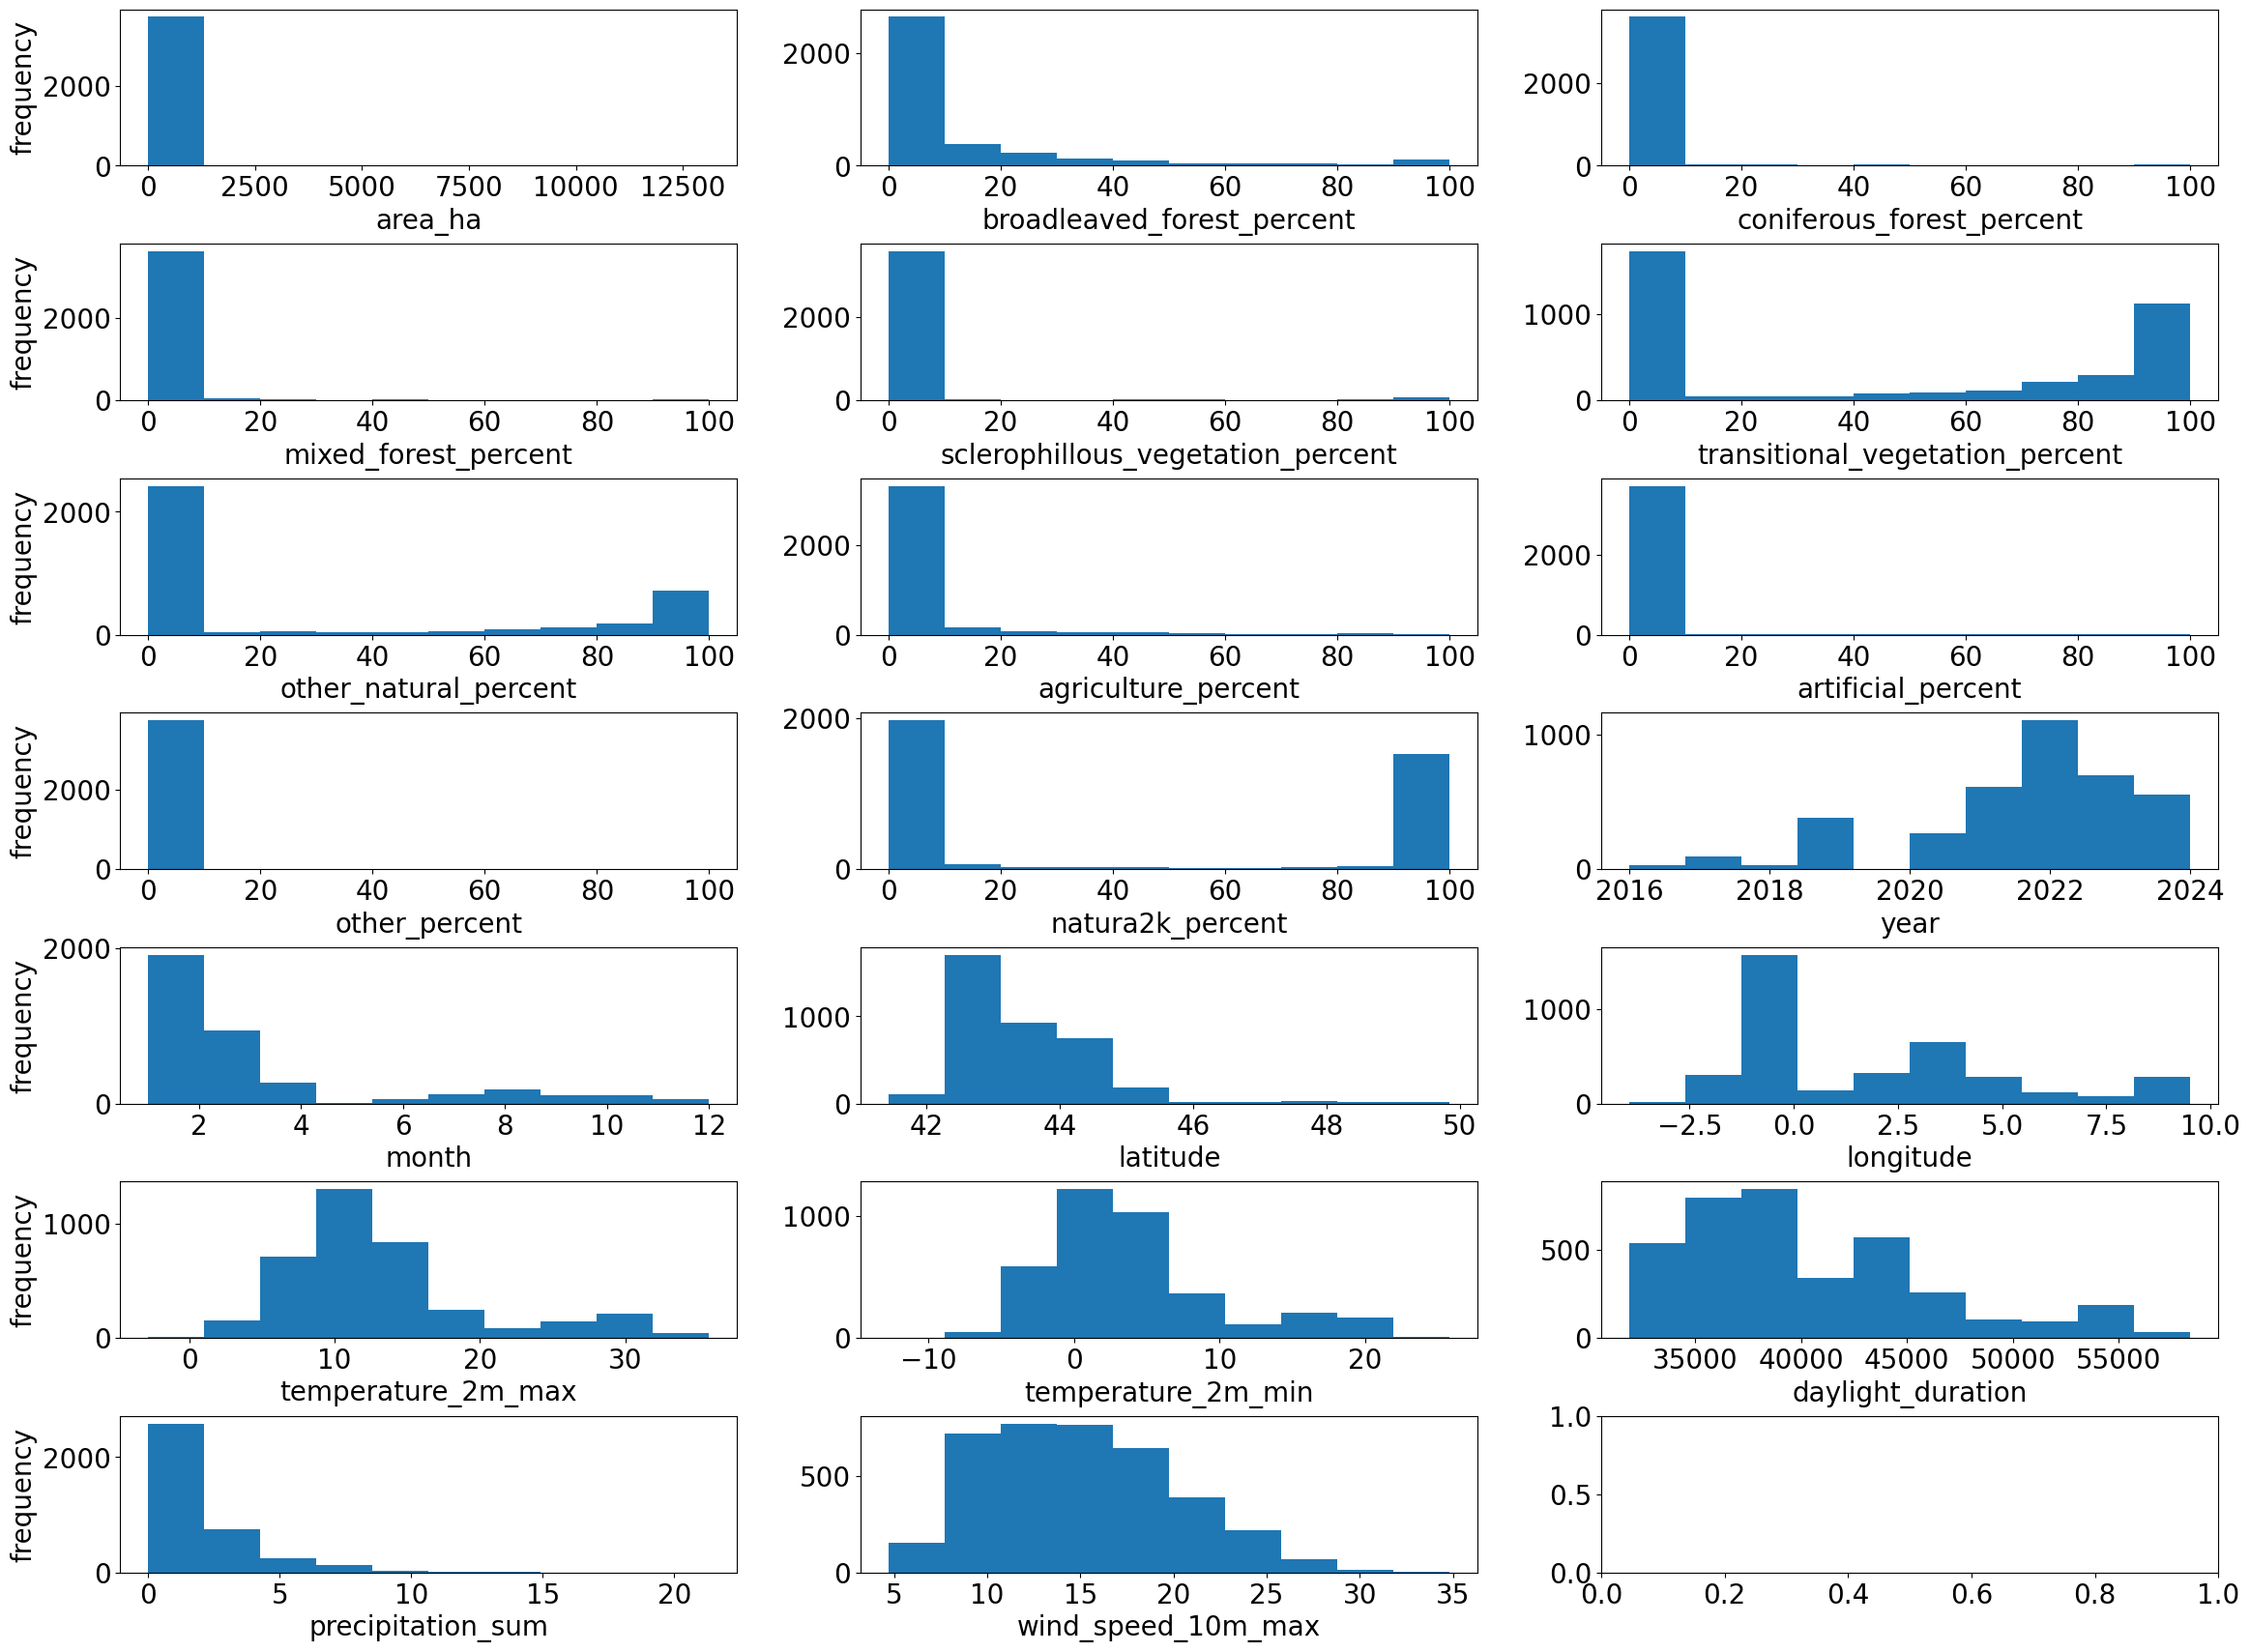

In [336]:
fig, ax = plt.subplots(7,3,figsize=(28,21))
plt.subplots_adjust(hspace=.5)
axes = ax.flatten()

for i, col in enumerate(newdf.columns[:-1]):
    newdf.plot(kind='hist', y=col, ax=axes[i], legend=False)
    if i%3==0:
        setaxes(axes[i], col, 'frequency', None, False)
    else:
        setaxes(axes[i], col, None, None, False)

2. exploring the types of burnt area

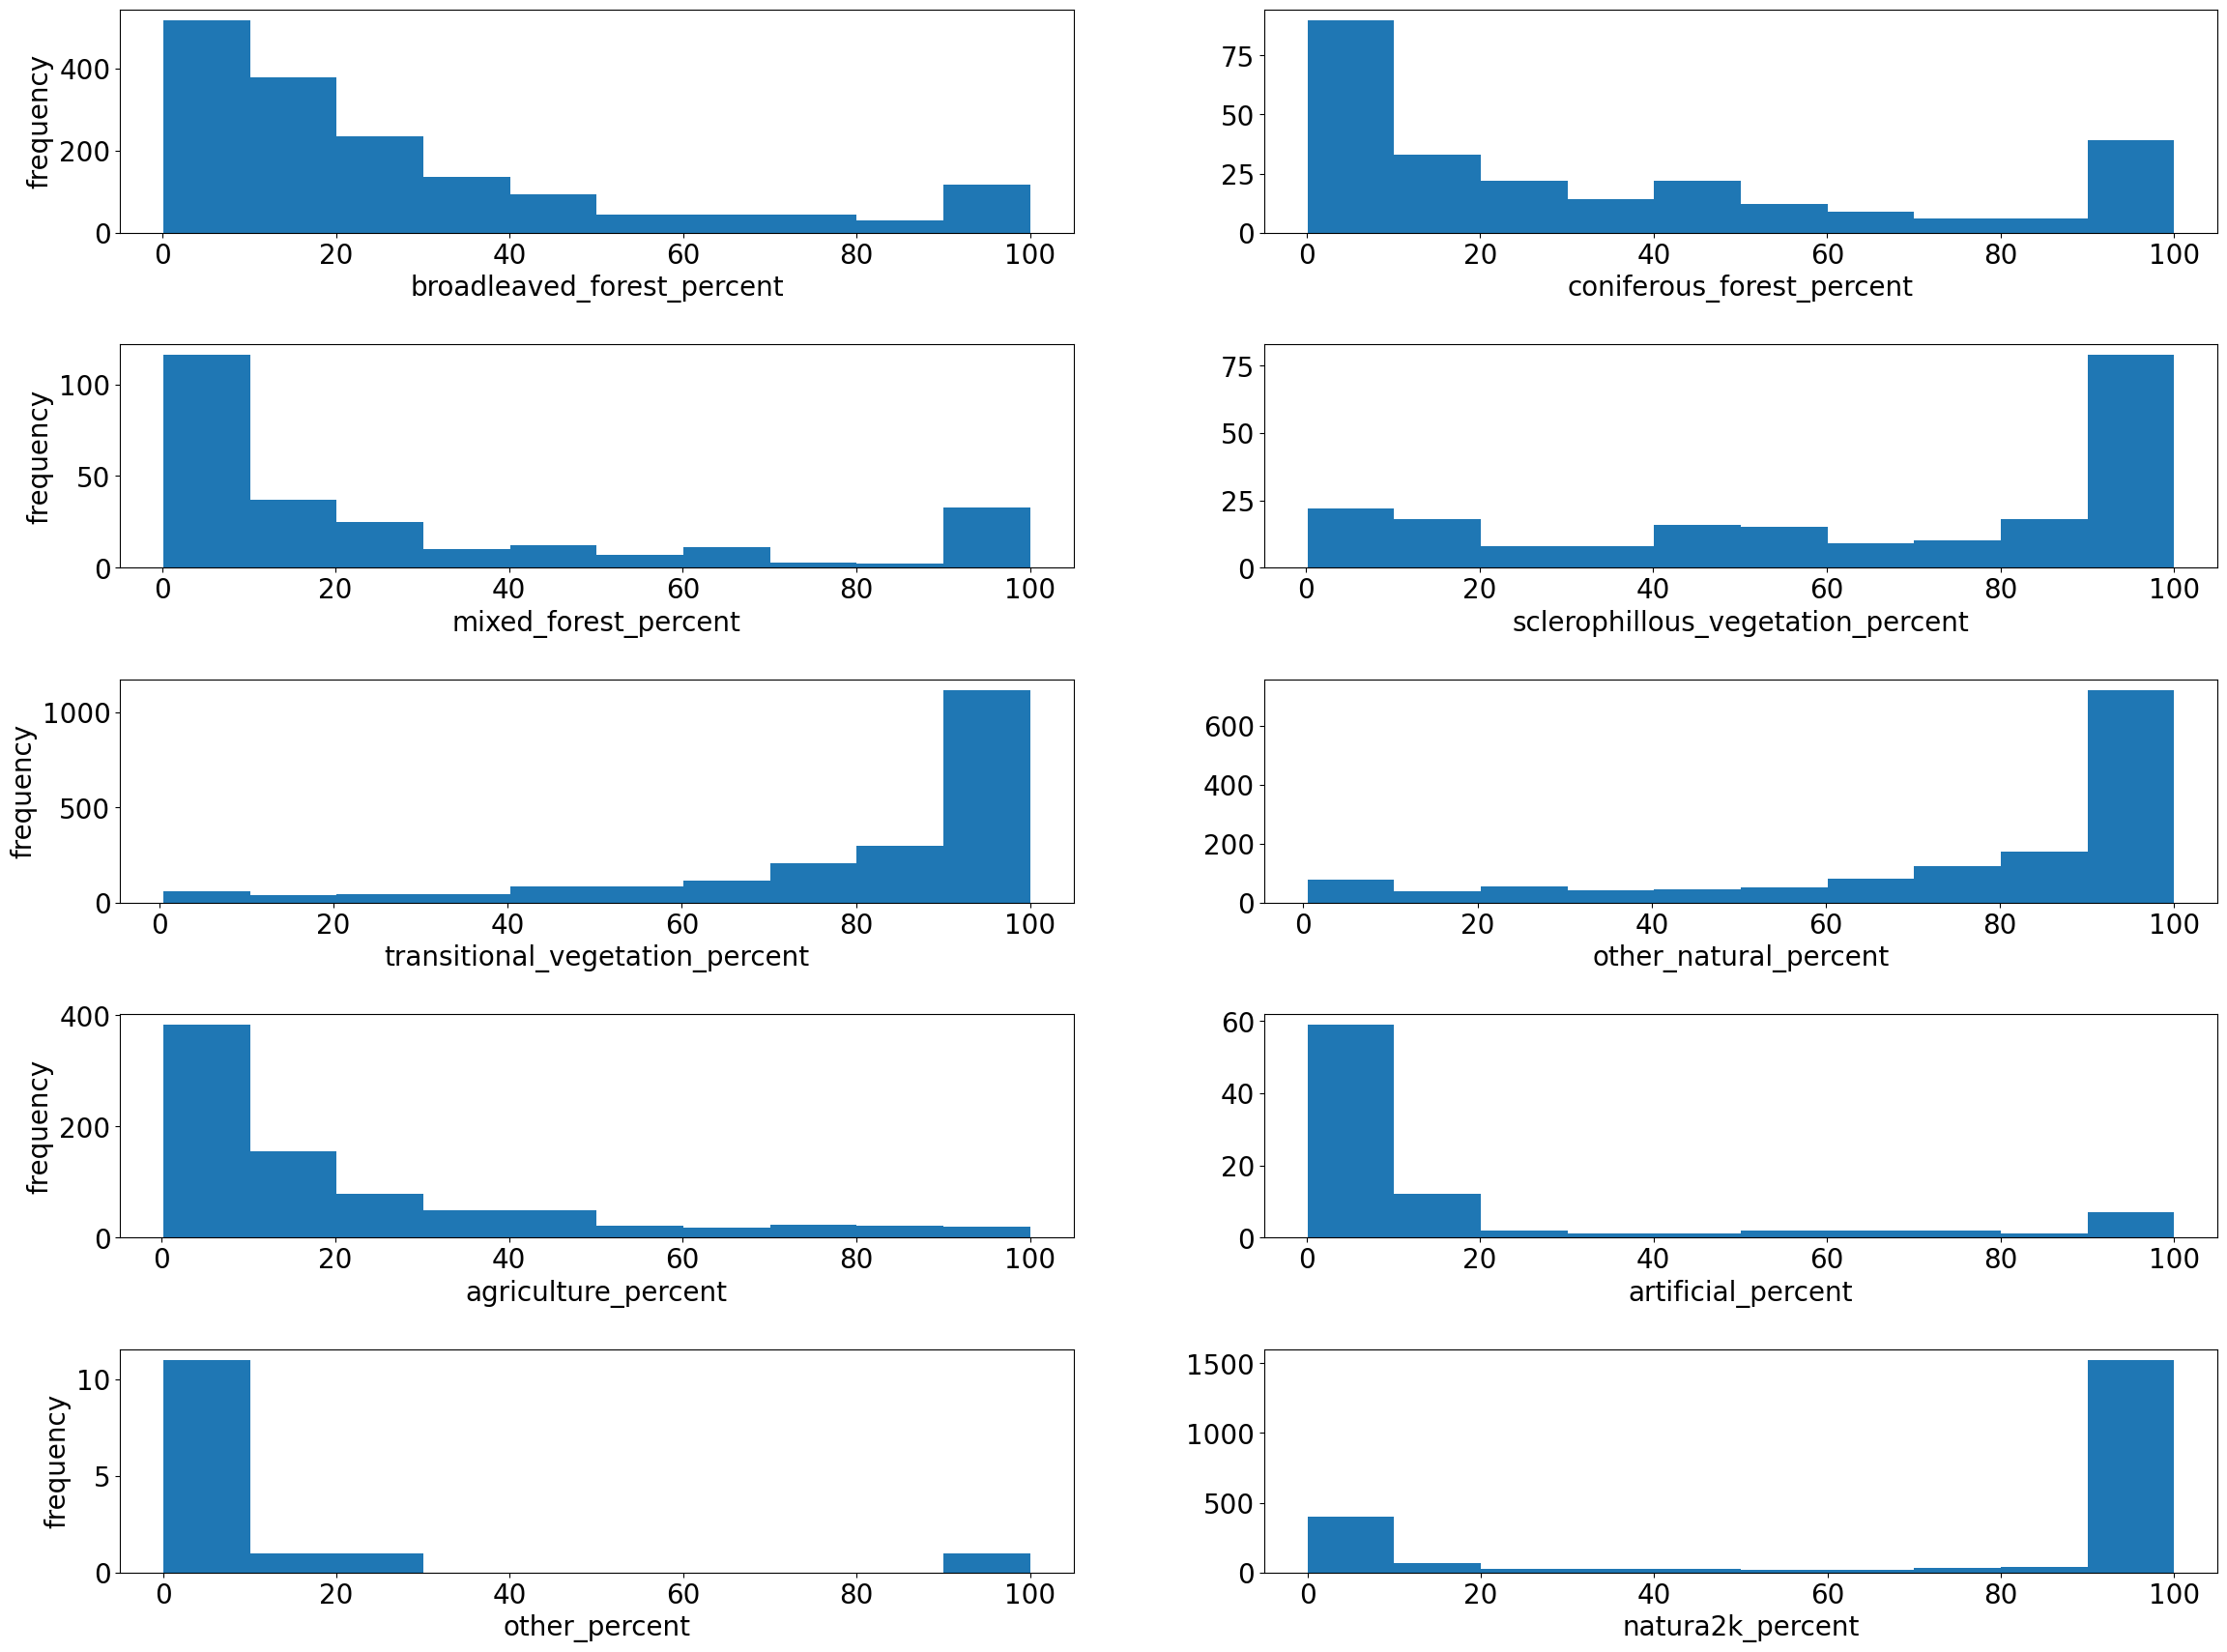

In [341]:
interesting_cols = ['broadleaved_forest_percent', 'coniferous_forest_percent',
       'mixed_forest_percent', 'sclerophillous_vegetation_percent',
       'transitional_vegetation_percent', 'other_natural_percent',
       'agriculture_percent', 'artificial_percent', 'other_percent',
       'natura2k_percent']

fig, ax = plt.subplots(5,2,figsize=(28,21))
axes = ax.flatten()
plt.subplots_adjust(hspace=.5)

for i, col in enumerate(interesting_cols):
    filtered_df = newdf[newdf[col] > 0]
    filtered_df.plot(kind='hist', y=col, ax=axes[i], legend=False)
    if i%2==0:
       setaxes(axes[i], col, 'frequency', None)
    else:
       setaxes(axes[i], col, None, None)


3. histograms of interesting columns considering the target "fire" yes or no

In [433]:
interesting_cols = ['area_ha', 'year', 'month', 'latitude', 'longitude',
       'temperature_2m_max', 'temperature_2m_min', 'daylight_duration',
       'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant','population']
len(interesting_cols)

12

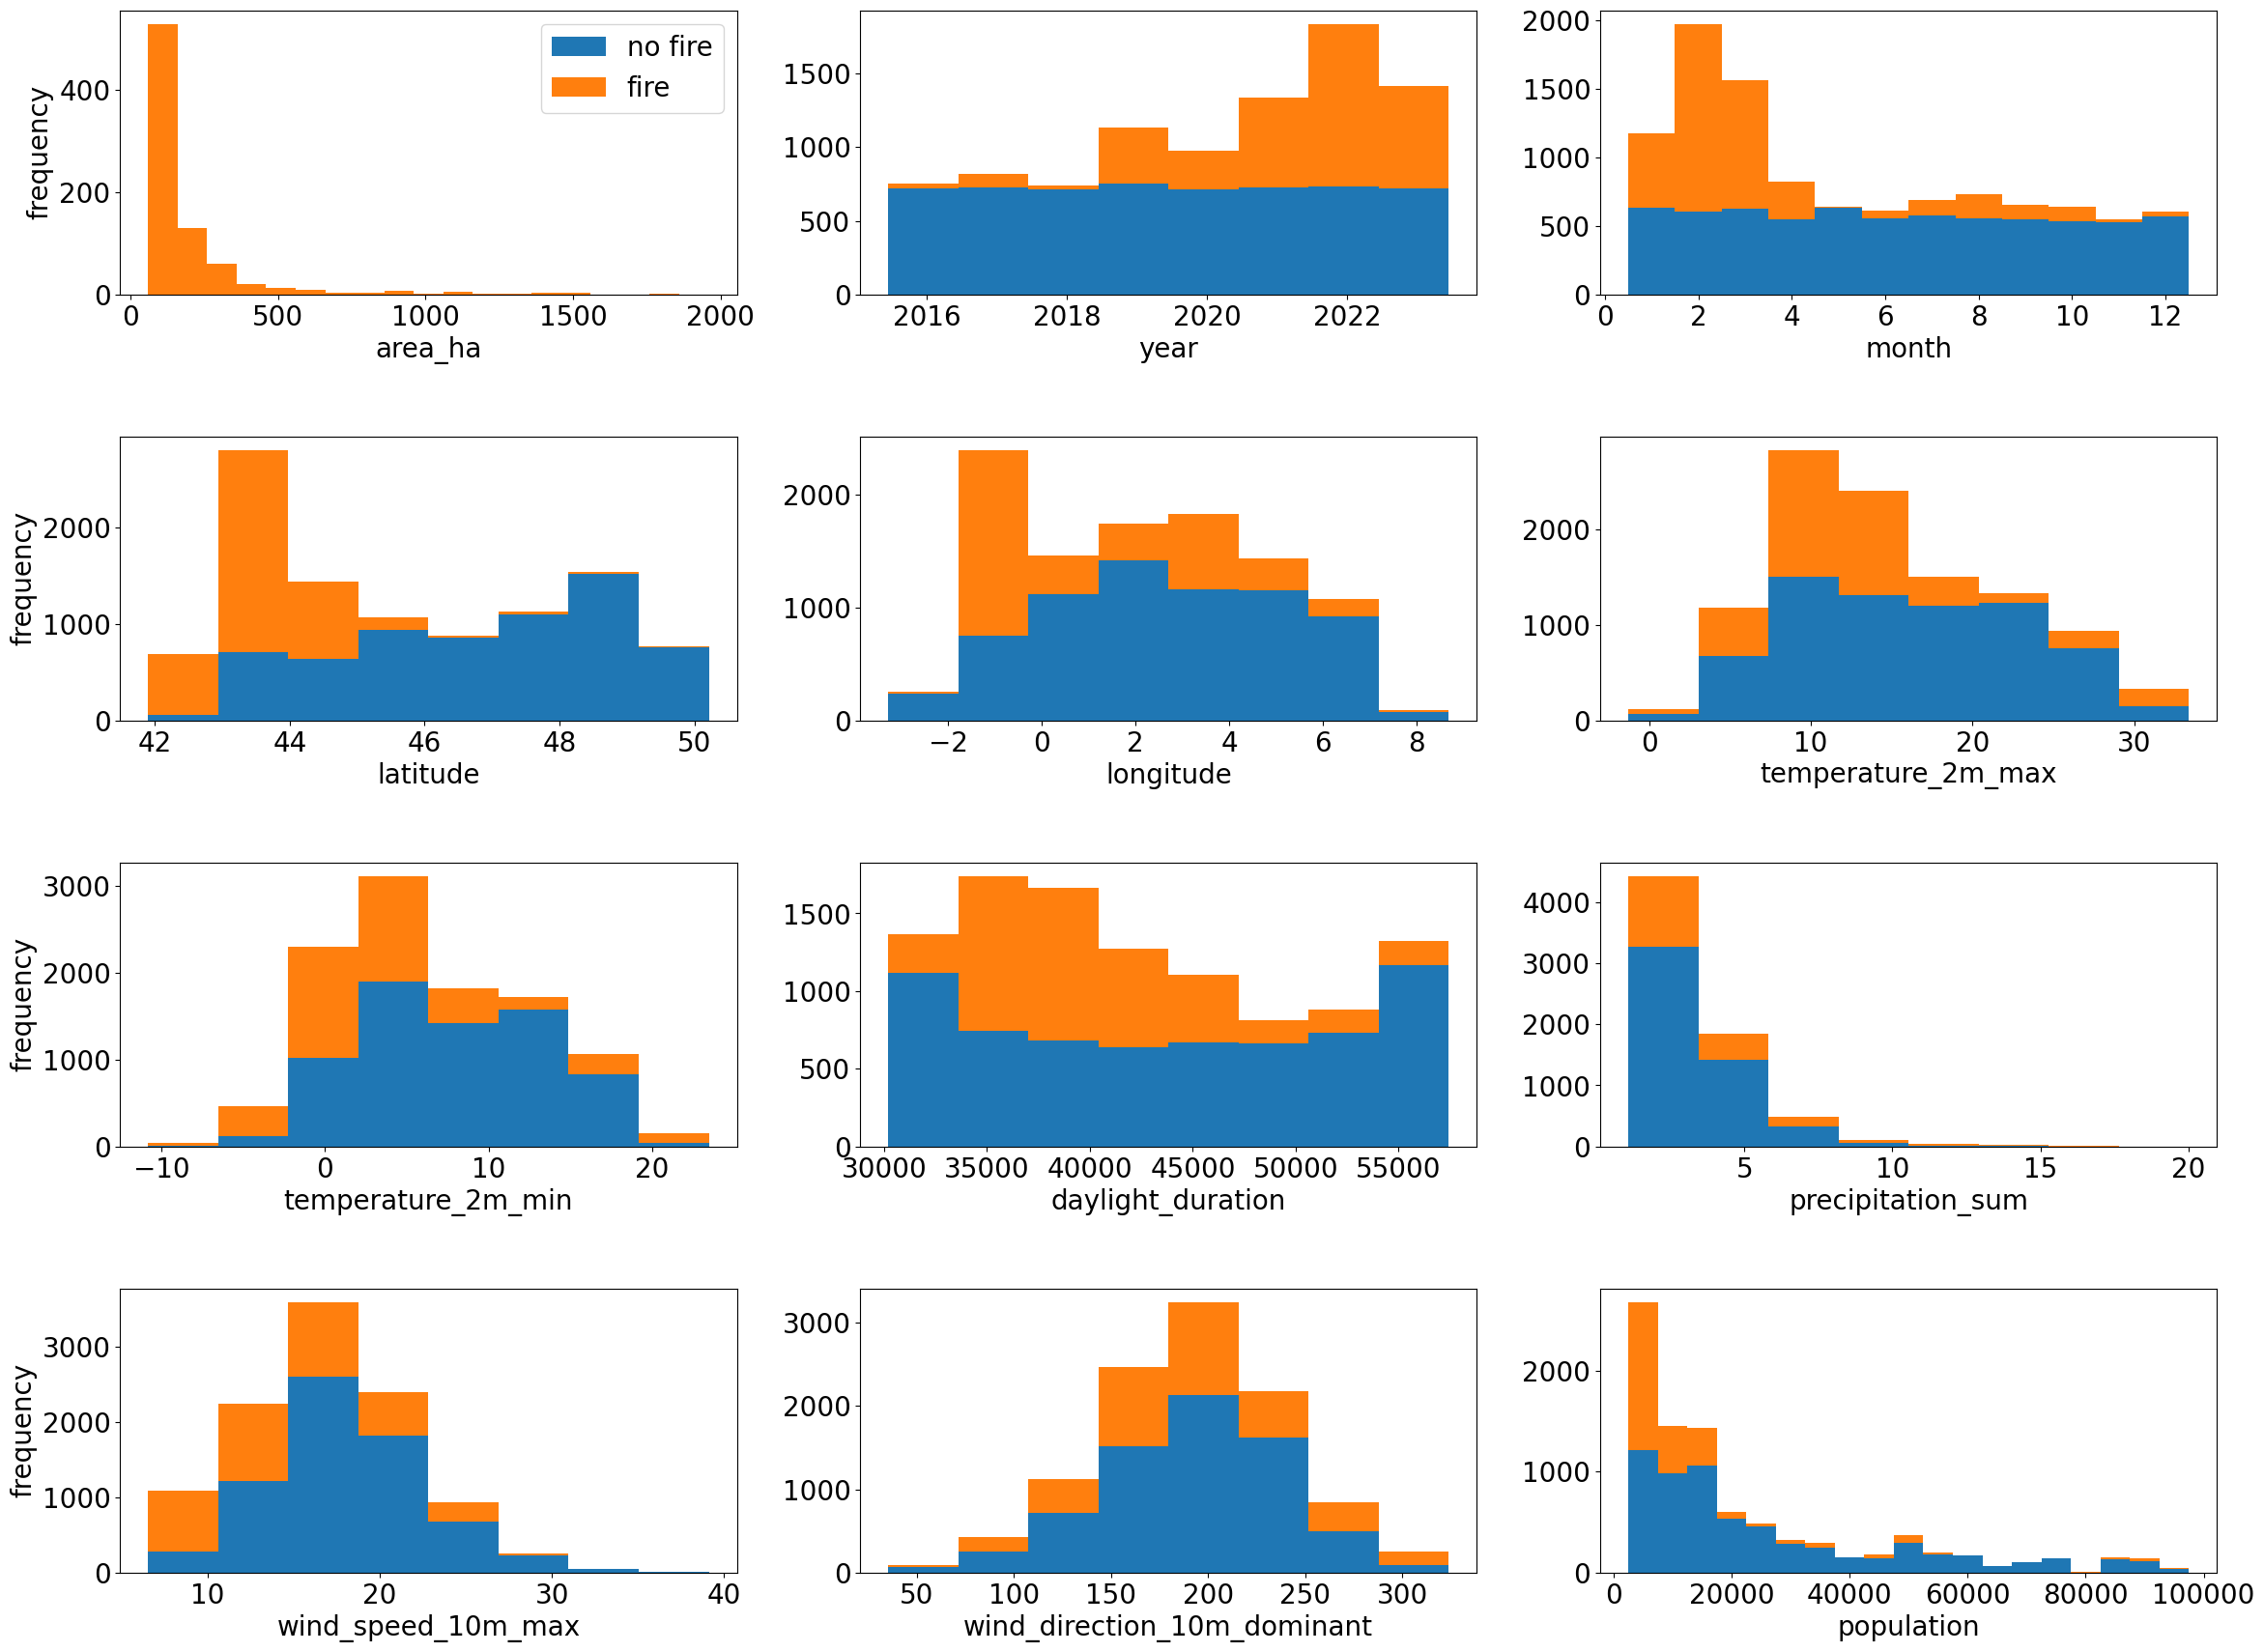

In [322]:
def getrange(df):
    return df.max() - df.min()

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(28,21))
plt.subplots_adjust(hspace=.5)
for c,a in enumerate(ax.ravel()):
    if c==0:
        bins=np.arange(10,2000,100)+50
    elif c==2:
        bins=np.arange(0,13,1)+.5
    elif c==11:
        bins=np.arange(0,1e5,5000)+2500
    else:
        r=getrange(df_combined[interesting_cols[c]])
        mm=df_combined[interesting_cols[c]].min()
        bins=np.arange(mm,mm+r,r/9)+r*.05
        # print(interesting_cols[c], r, bins)
  
    a.hist(df_combined.pivot(columns='fire')[interesting_cols[c]], bins=bins, histtype='bar', stacked='True')
    a.set_xlabel(interesting_cols[c])
    if c==0:
        a.legend(['no fire','fire'], fontsize=med)
    if c%3==0:
        a.set_ylabel('frequency')

## Boxplots & Outliers

In [46]:
df_combined['lat'] = df_combined['latitude'].astype(int)

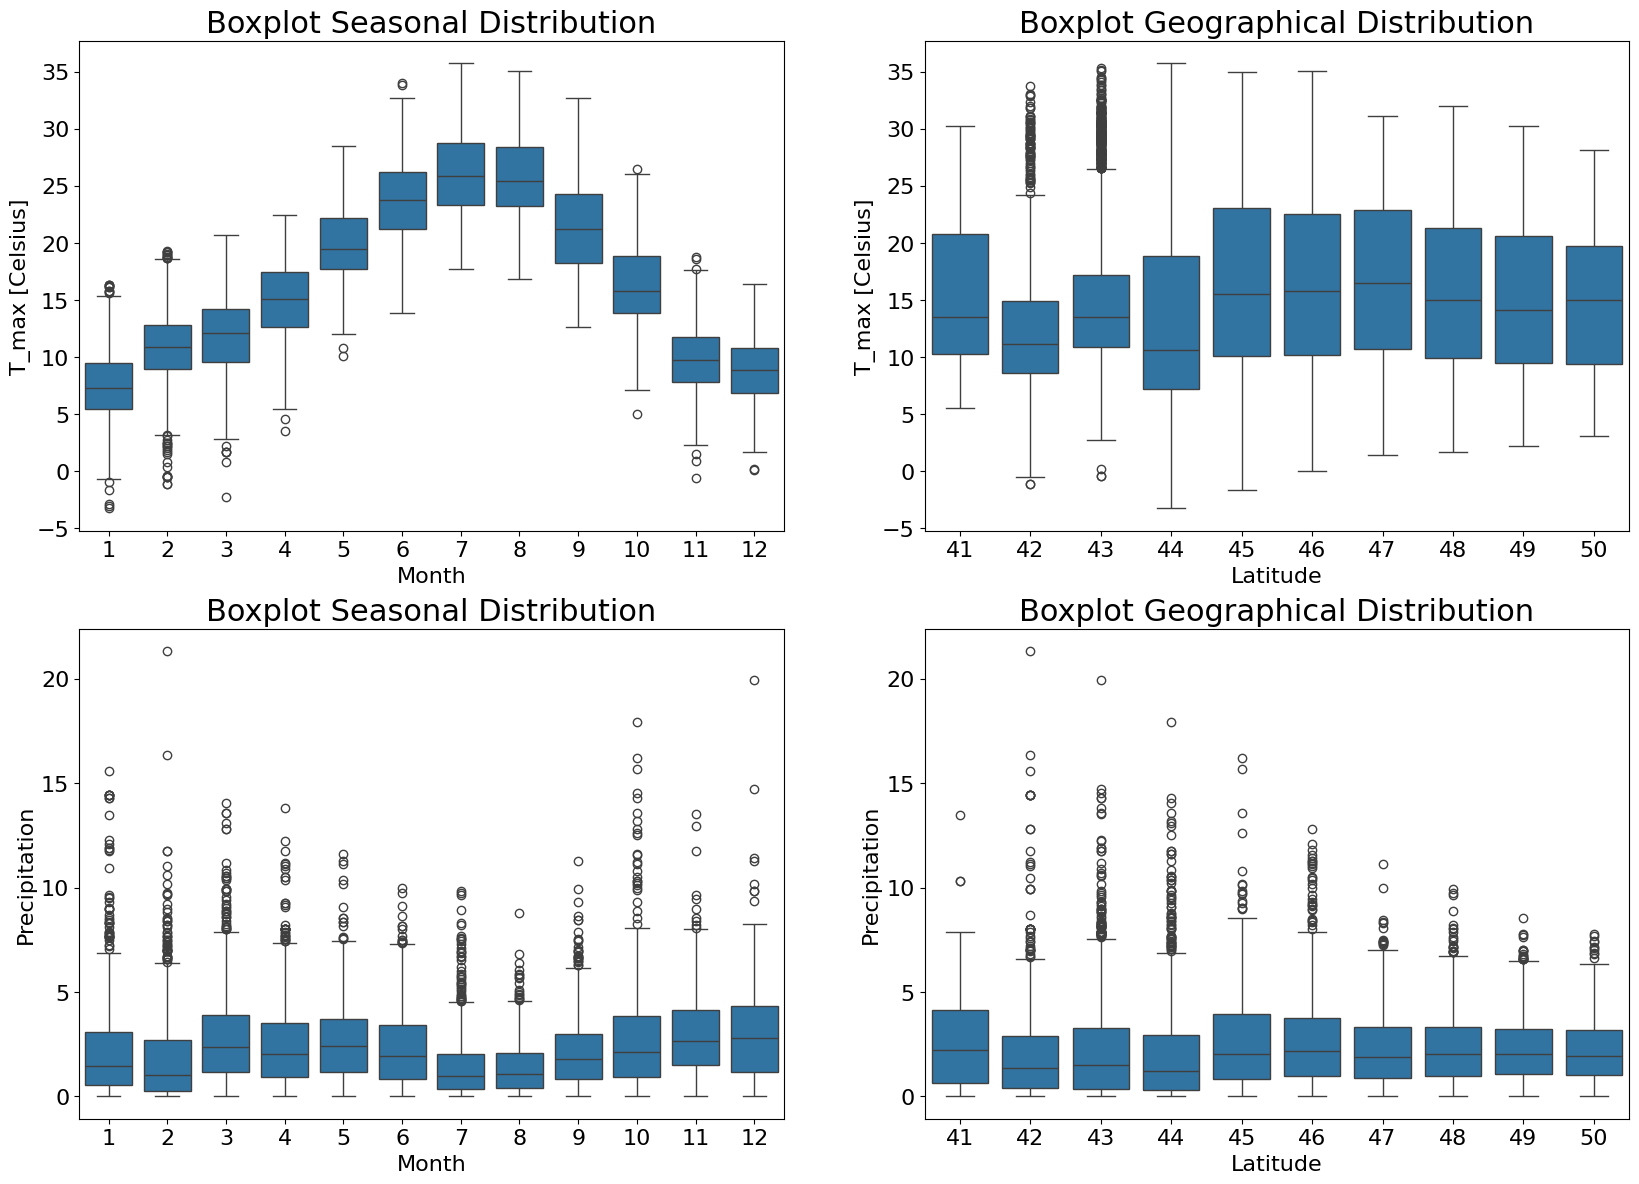

In [53]:
fig, (ax,ay) = plt.subplots(2,2,figsize=(20,14))

sns.boxplot(x='month', y='temperature_2m_max', data=df_combined, ax=ax[0])
setaxes(ax[0], 'Month', 'T_max [Celsius]', 'Boxplot Seasonal Distribution', False)
sns.boxplot(x='lat', y='temperature_2m_max', data=df_combined, ax=ax[1])
setaxes(ax[1], 'Latitude', 'T_max [Celsius]', 'Boxplot Geographical Distribution', False)

sns.boxplot(x='month', y='precipitation_sum', data=df_combined, ax=ay[0])
setaxes(ay[0], 'Month', 'Precipitation', 'Boxplot Seasonal Distribution', False)
sns.boxplot(x='lat', y='precipitation_sum', data=df_combined, ax=ay[1])
setaxes(ay[1], 'Latitude', 'Precipitation', 'Boxplot Geographical Distribution', False)

# sns.boxplot(x='month', y='area_ha', data=df_combined[df_combined['area_ha']>0], ax=az[0])
# setaxes(az[0], 'Month', 'Precipitation', 'Boxplot Seasonal Distribution', False)
# sns.boxplot(x='lat', y='area_ha', data=df_combined[df_combined['area_ha']>0], ax=az[1])
# setaxes(az[1], 'Latitude', 'Precipitation', 'Boxplot Geographical Distribution', False)

# rot=40
# ax[0].tick_params(axis='x', rotation=rot)
# ax[1].tick_params(axis='x', rotation=0)

## Multicollinearity

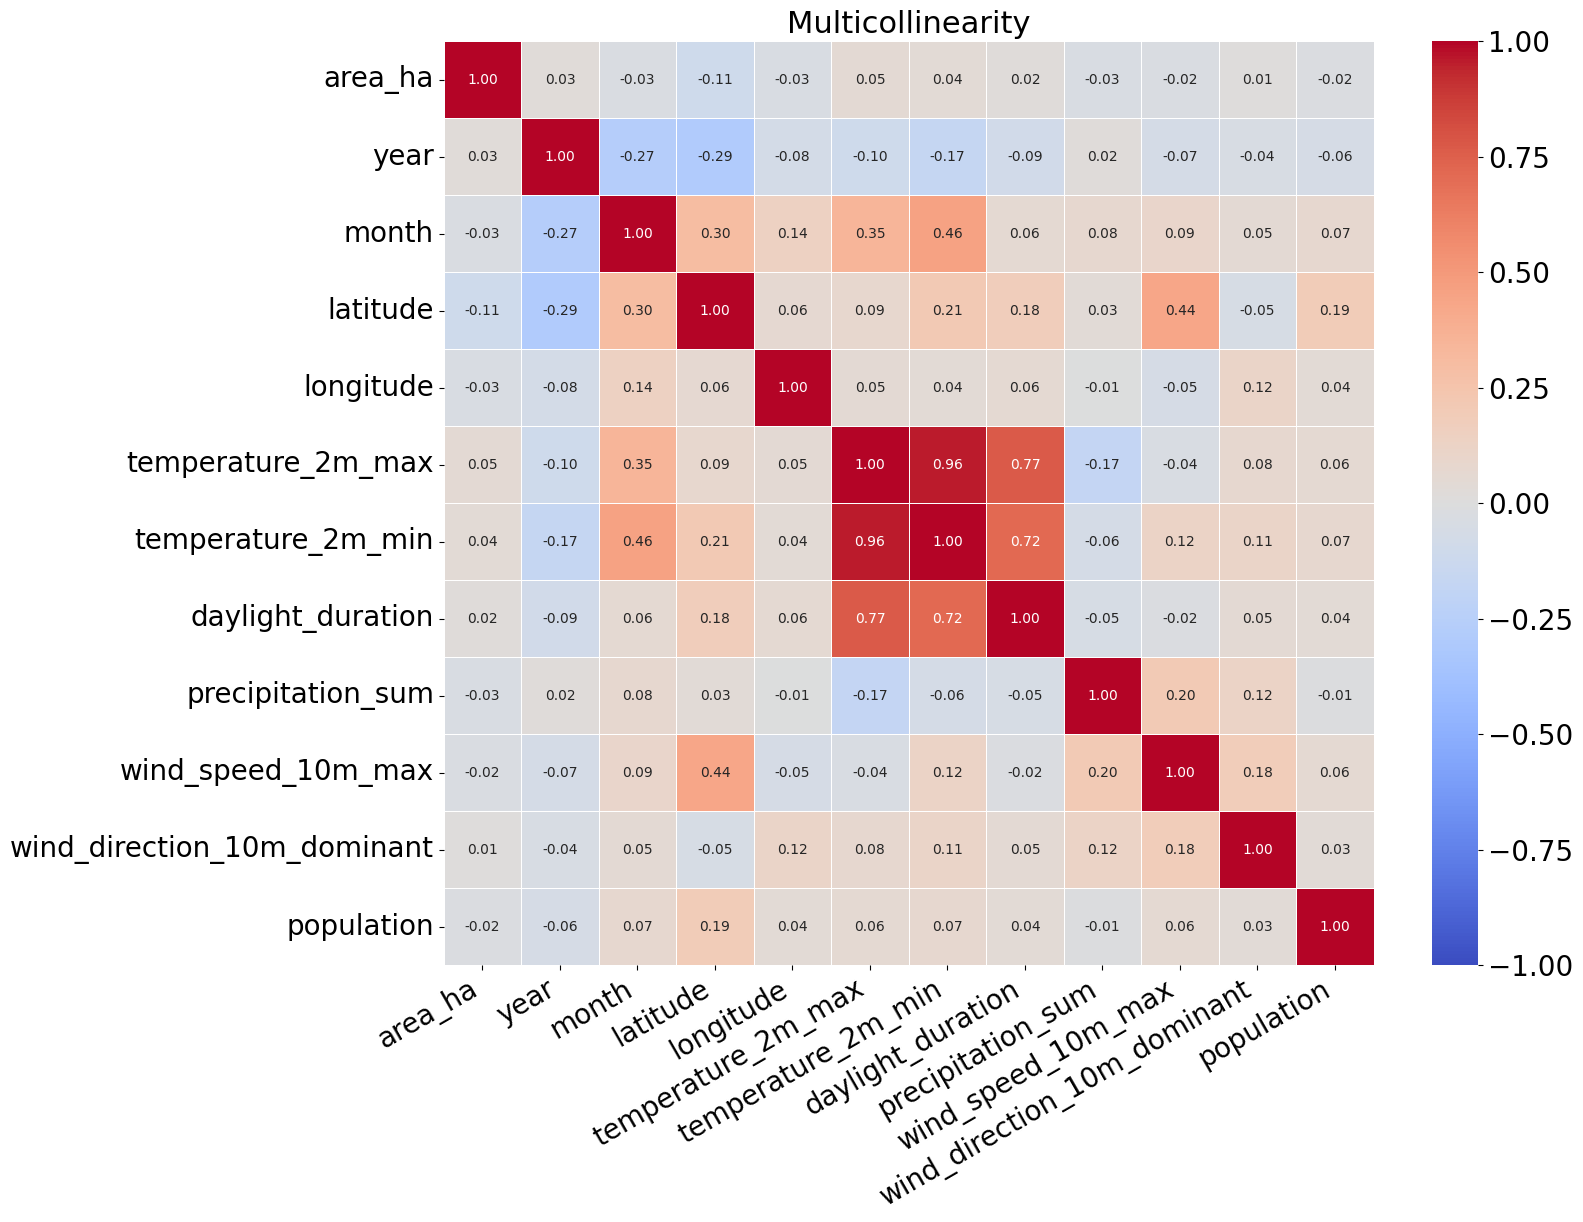

In [435]:
correlation_matrix = df_combined[interesting_cols].corr()

# Display the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Multicollinearity')
plt.xticks(rotation=30, ha='right')
plt.show()

In [438]:
df_combined.drop(columns={'temperature_2m_min','initialdate', 'finaldate','region', 'department','community'}, inplace=True)

## scatterplot

In [397]:
interesting_cols = ['area_ha', 'year', 'month', 'latitude', 'longitude',
       'temperature_2m_max', 'daylight_duration',
       'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant']

In [401]:
colset = ['area_ha', 'month', 'latitude', 'longitude',
       'temperature_2m_max', 'daylight_duration', 'precipitation_sum',
       'wind_speed_10m_max', 'wind_direction_10m_dominant', 'population']

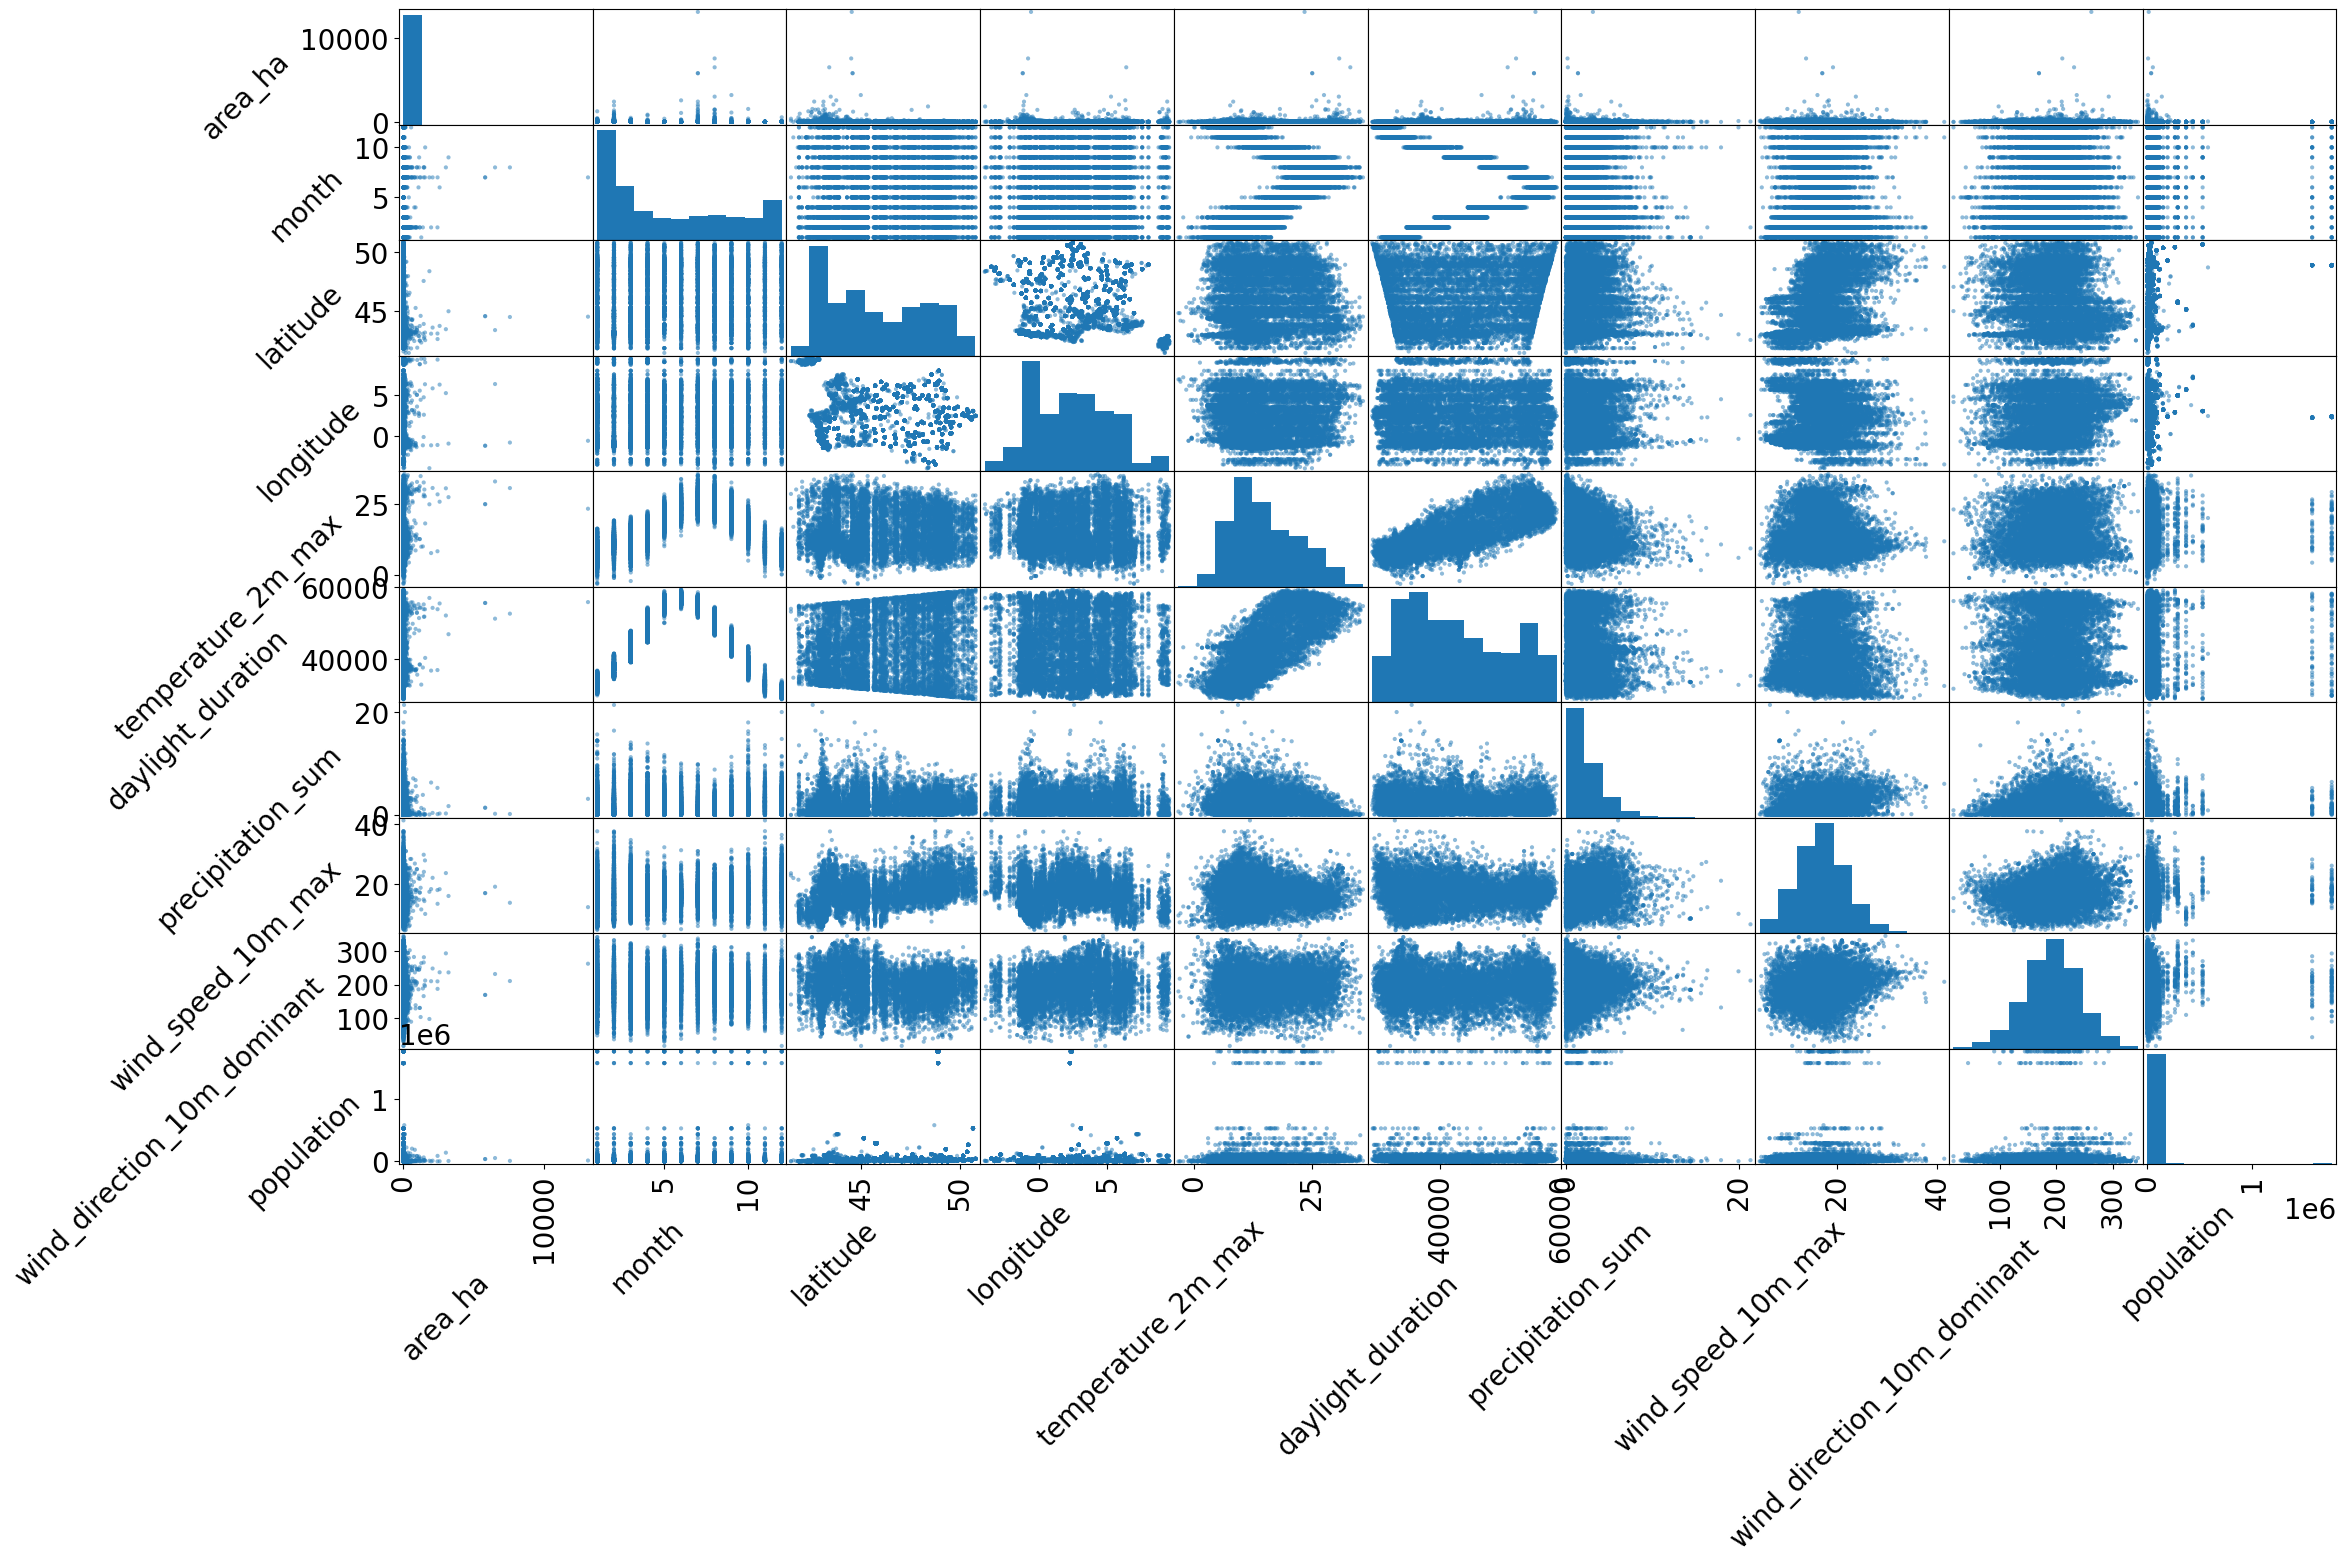

In [404]:
ax = pd.plotting.scatter_matrix(df_combined[colset],figsize=(25,15))
for axx in ax.flatten():
    axx.yaxis.label.set_rotation(45)
    axx.xaxis.label.set_rotation(45)
    axx.yaxis.label.set_ha('right')
    axx.xaxis.label.set_ha('right')
    axx.tick_params(axis='both', labelsize=med)

In [56]:
colset = ['area_ha', 'broadleaved_forest_percent', 'coniferous_forest_percent',
       'mixed_forest_percent', 'sclerophillous_vegetation_percent',
       'transitional_vegetation_percent', 'other_natural_percent',
       'agriculture_percent', 'artificial_percent', 'other_percent',
       'natura2k_percent']

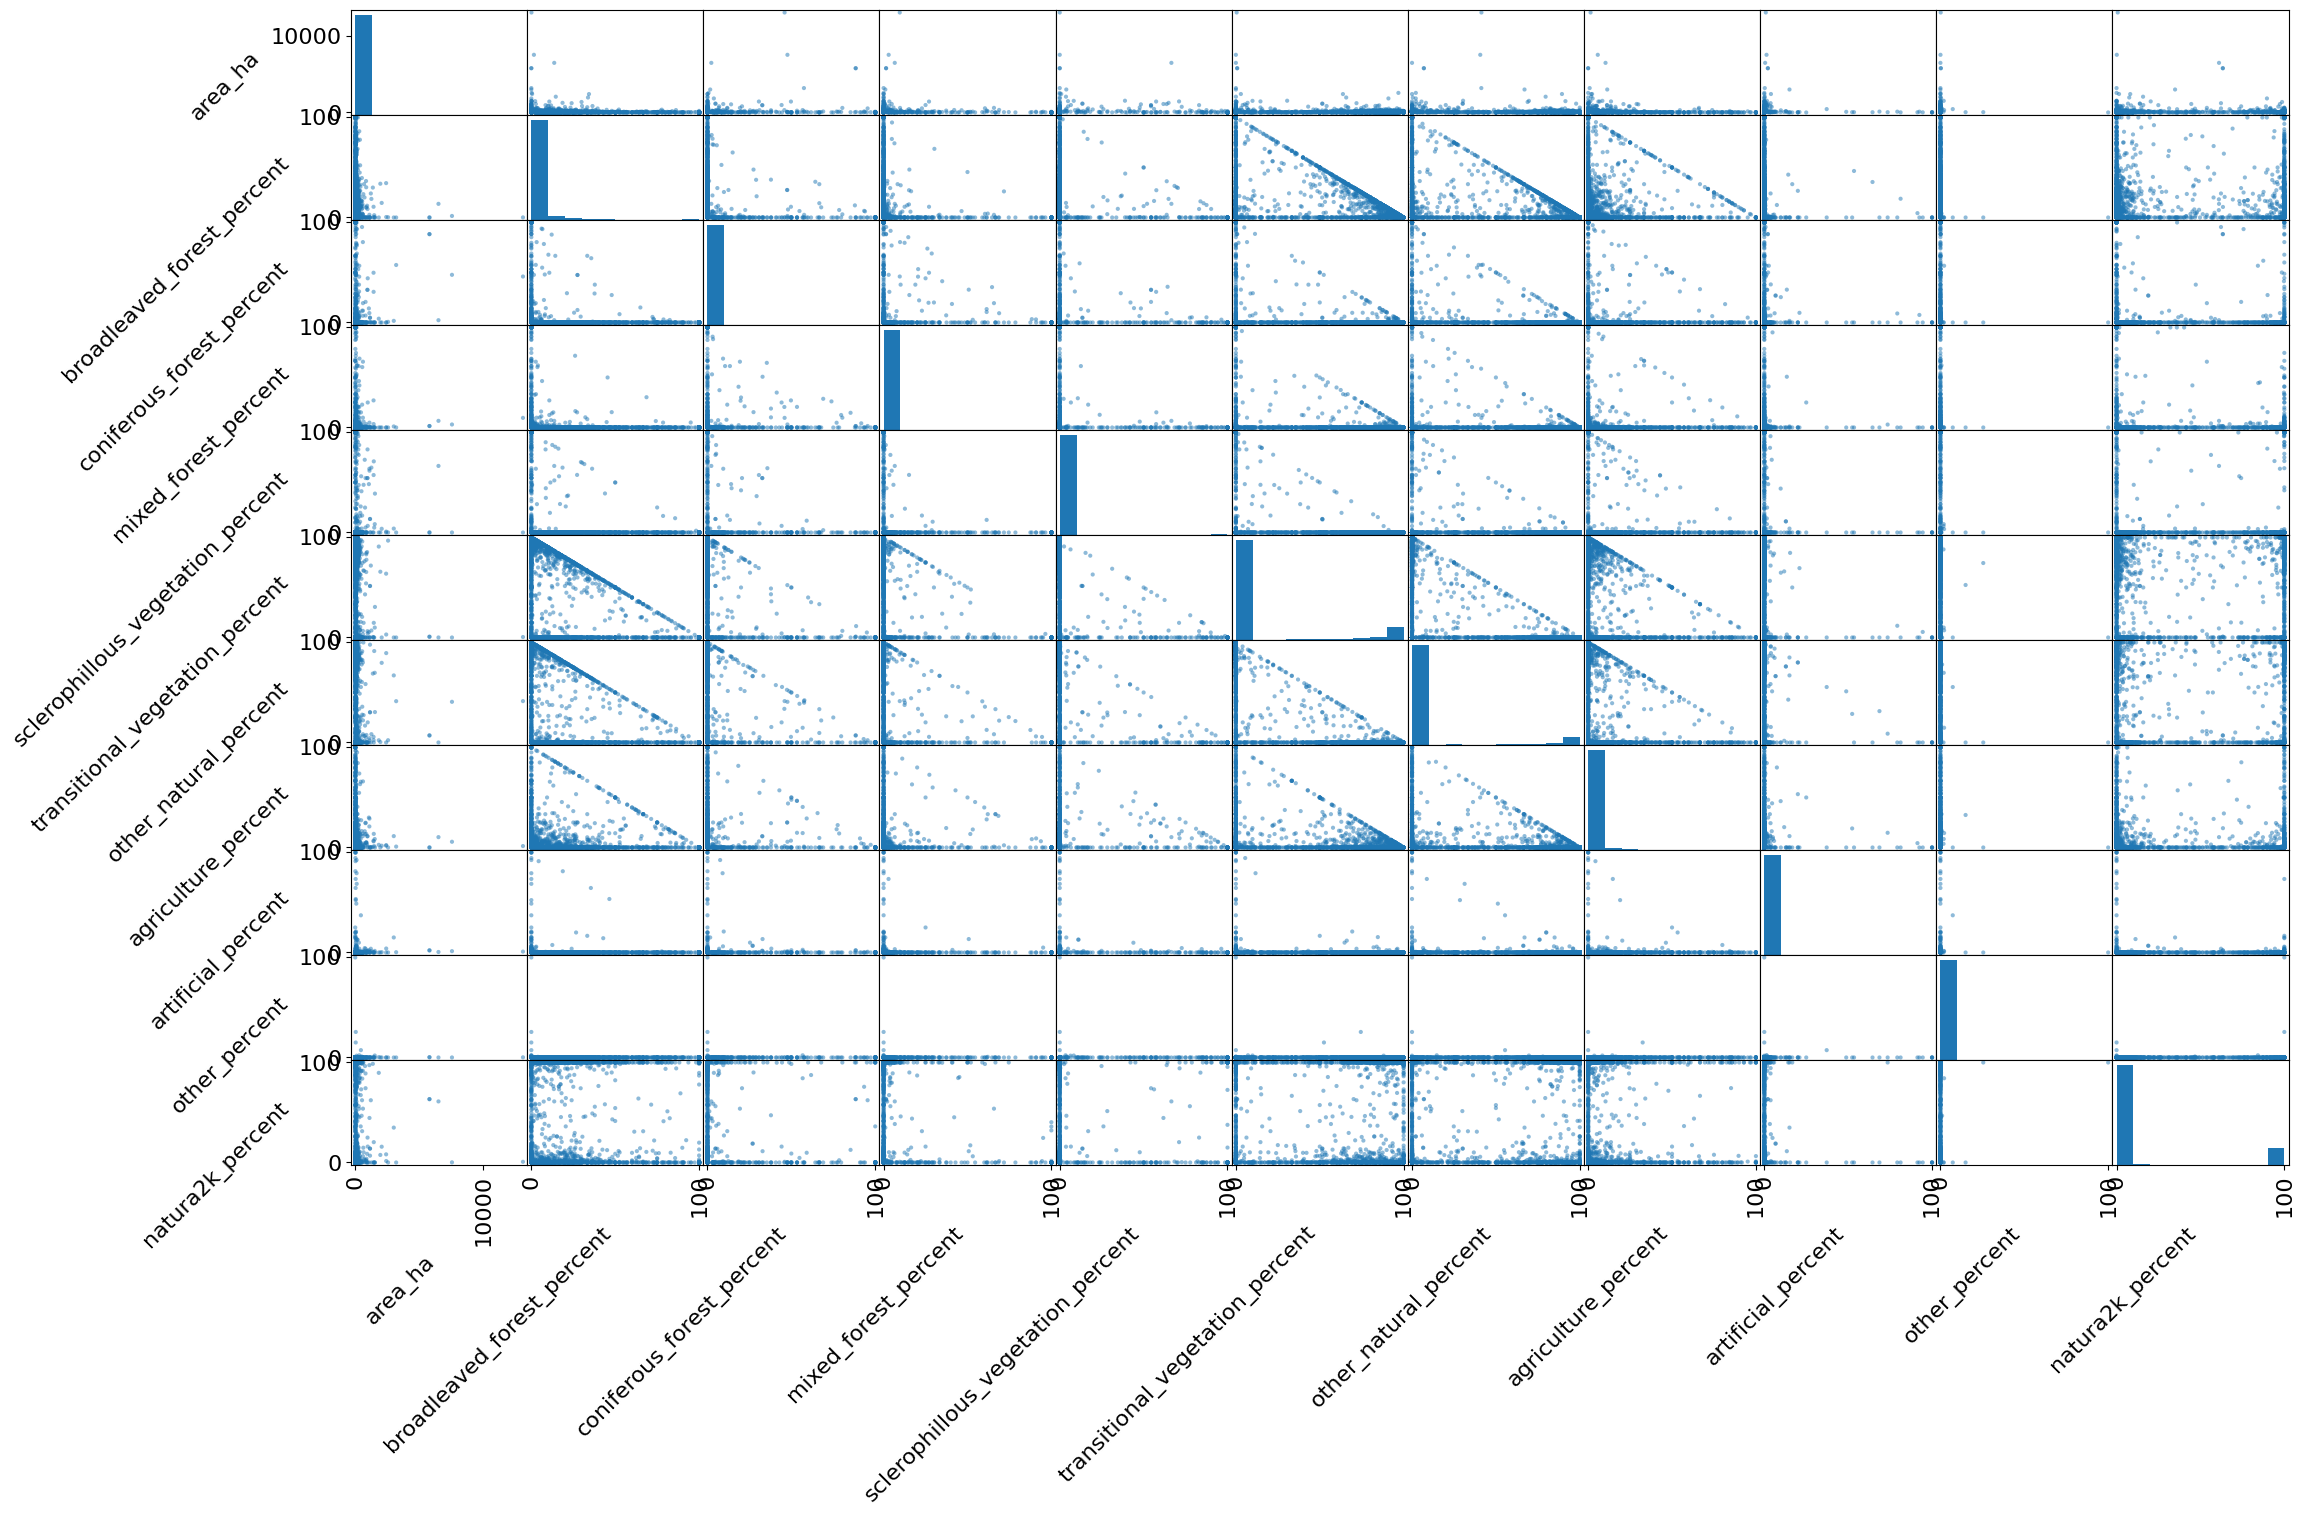

In [58]:
ax = pd.plotting.scatter_matrix(df_combined[colset],figsize=(25,15))
for axx in ax.flatten():
    axx.yaxis.label.set_rotation(45)
    axx.xaxis.label.set_rotation(45)
    axx.yaxis.label.set_ha('right')
    axx.xaxis.label.set_ha('right')
    axx.tick_params(axis='both', labelsize=med)

# Model building

In [481]:
df_backup=df_combined.copy()

In [500]:
df_backup.columns

Index(['year', 'month', 'latitude', 'longitude', 'temperature_2m_max',
       'daylight_duration', 'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'fire', 'population', 'neighbor'],
      dtype='object')

## 1. fire yes-no on weather dependence classifier

In [545]:
df_combined=df_backup.copy()

In [ ]:
# just checking for weather dependence
df_combined.drop(columns={'area_ha', 'year', 'month', 'latitude', 'longitude', 'broadleaved_forest_percent', 'coniferous_forest_percent',
       'mixed_forest_percent', 'sclerophillous_vegetation_percent',
       'transitional_vegetation_percent', 'other_natural_percent',
       'agriculture_percent', 'artificial_percent', 'other_percent',
       'natura2k_percent'}, inplace=True)

In [547]:
df_combined.drop(columns={'population', 'neighbor'}, inplace=True)

In [548]:
df_combined.columns

Index(['year', 'month', 'latitude', 'longitude', 'temperature_2m_max',
       'daylight_duration', 'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'fire'],
      dtype='object')

In [549]:
X = df_combined.drop('fire', axis=1)  # Drop the target column to get features
y = df_combined['fire']  # Target variable

# Optional: Normalize the features (important for some models like SVM and KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### kNN

In [550]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2049
           1       0.90      0.93      0.92      1149

    accuracy                           0.94      3198
   macro avg       0.93      0.94      0.94      3198
weighted avg       0.94      0.94      0.94      3198



Text(31.722222222222214, 0.5, 'True Label')

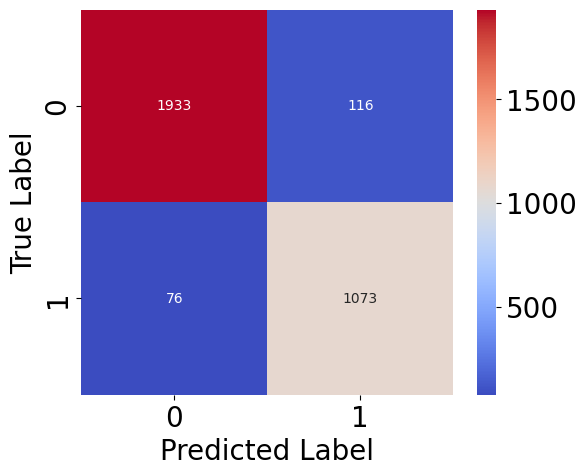

In [551]:
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6,5))
sns.heatmap(cm, fmt='d', annot=True, cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### DecisionTreeClassifier

In [552]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2049
           1       0.94      0.93      0.93      1149

    accuracy                           0.95      3198
   macro avg       0.95      0.95      0.95      3198
weighted avg       0.95      0.95      0.95      3198



Text(31.722222222222214, 0.5, 'True Label')

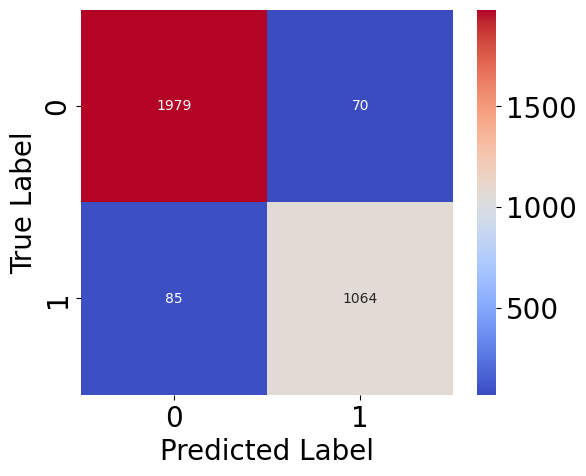

In [553]:
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,5))
sns.heatmap(cm, fmt='d', annot=True, cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### RandomForestClassifier

In [554]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2049
           1       0.97      0.94      0.96      1149

    accuracy                           0.97      3198
   macro avg       0.97      0.96      0.97      3198
weighted avg       0.97      0.97      0.97      3198



Text(31.722222222222214, 0.5, 'True Label')

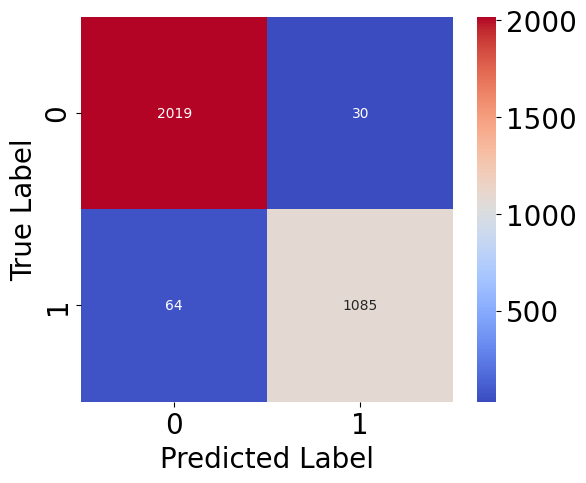

In [555]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, fmt='d', annot=True, cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### GradientBoostClassifier

In [556]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2049
           1       0.95      0.94      0.95      1149

    accuracy                           0.96      3198
   macro avg       0.96      0.96      0.96      3198
weighted avg       0.96      0.96      0.96      3198



Text(31.722222222222214, 0.5, 'True Label')

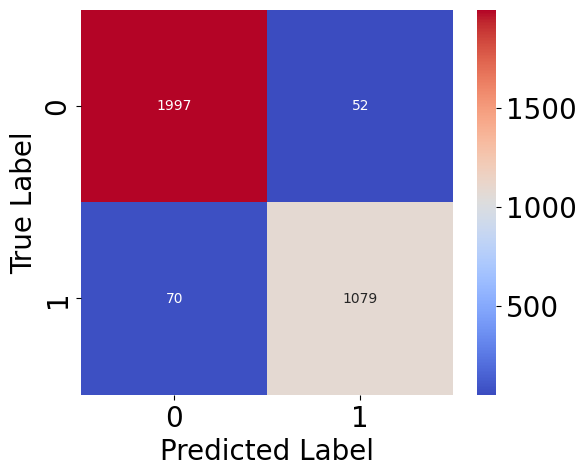

In [557]:
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, fmt='d', annot=True, cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### SVM & SHAP & LIME

In [558]:
from sklearn.svm import SVC

# Initialize and train SVM
svm = SVC(kernel='linear', random_state=42)  # 'linear' kernel for simplicity
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2049
           1       0.87      0.87      0.87      1149

    accuracy                           0.91      3198
   macro avg       0.90      0.90      0.90      3198
weighted avg       0.91      0.91      0.91      3198



Text(31.722222222222214, 0.5, 'True Label')

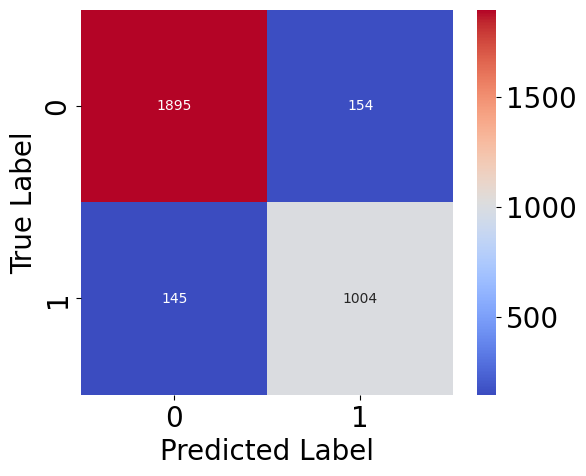

In [559]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, fmt='d', annot=True, cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### Compare performance

In [560]:
# Example: Comparing accuracy
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


KNN Accuracy: 0.9399624765478424
Decision Tree Accuracy: 0.9515322076297686
Random Forest Accuracy: 0.9706066291432145
Gradient Boosting Accuracy: 0.9618511569731082
SVM Accuracy: 0.9065040650406504


Text(0, 0.5, 'Importance Score')

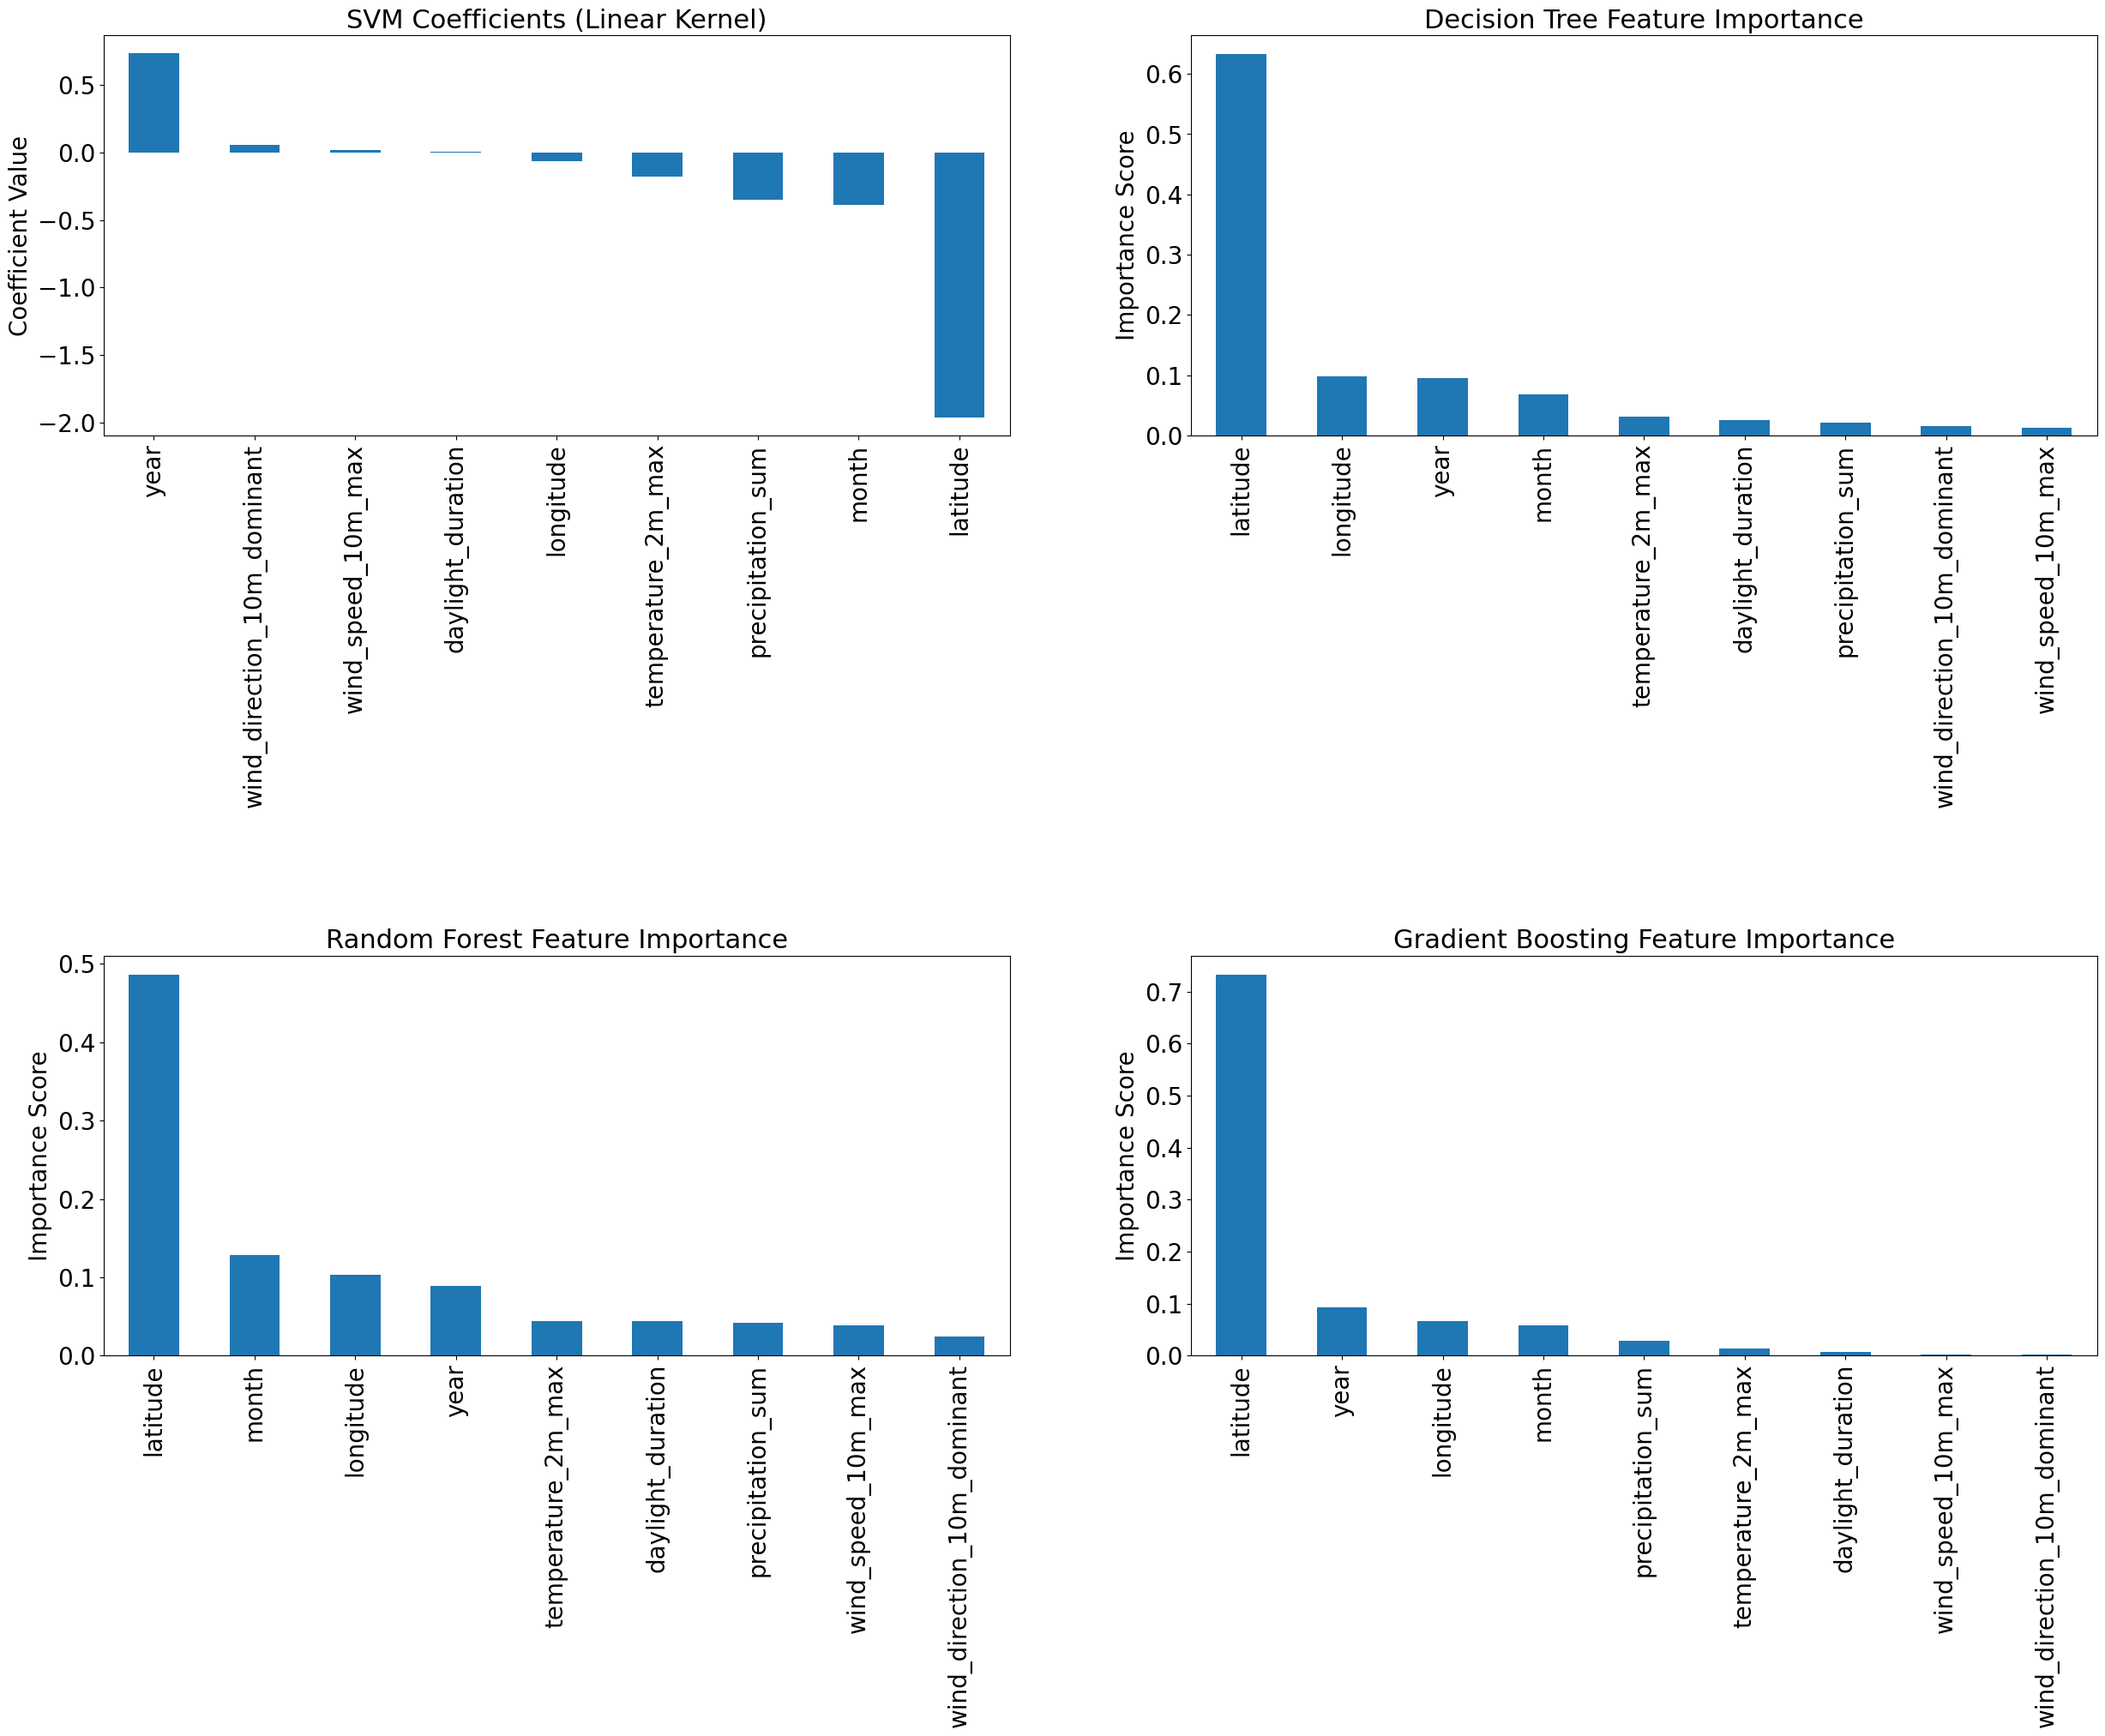

In [561]:
svm_coefs = pd.Series(svm.coef_[0], index=X.columns).sort_values(ascending=False)

# Extract feature importances from Decision Tree, Random Forest, and Gradient Boosting
dt_importances = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
gb_importances = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot the coefficients and feature importances
plt.figure(figsize=(30, 20))
plt.subplots_adjust(hspace=1.3)

plt.subplot(2, 2, 1)
svm_coefs.plot(kind='bar')
plt.title("SVM Coefficients (Linear Kernel)")
plt.ylabel("Coefficient Value")

plt.subplot(2, 2, 2)
dt_importances.plot(kind='bar')
plt.title("Decision Tree Feature Importance")
plt.ylabel("Importance Score")

plt.subplot(2, 2, 3)
rf_importances.plot(kind='bar')
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance Score")

plt.subplot(2, 2, 4)
gb_importances.plot(kind='bar')
plt.title("Gradient Boosting Feature Importance")
plt.ylabel("Importance Score")

In [562]:
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                      np.arange(y_min, y_max, 0.1))

# # Predict class labels for the grid points
# Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # Plot the decision boundary and the training points
# plt.contourf(xx, yy, Z, alpha=0.4)
# plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')
# plt.title('KNN Decision Boundary')

### HyperParameterOptimization

## 2. fire size on type and weather

In [563]:
df_combined = df_backup.copy()

# just checking for weather dependence
df_combined.drop(columns={'fire'}, inplace=True)

X = df_combined.drop('area_ha', axis=1)  # Drop the target column to get features
y = df_combined['area_ha']  # Target variable

# Optional: Normalize the features (important for some models like SVM and KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

KeyError: "['area_ha'] not found in axis"

In [321]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr.predict(X_test)

In [322]:
from sklearn.tree import DecisionTreeRegressor

# Initialize and train Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt.predict(X_test)

In [323]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)


In [324]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb.predict(X_test)


In [325]:
# Function to calculate and print evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")
    print("-" * 30)

# Evaluate all models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_dt, "Decision Tree Regressor")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regressor")


Linear Regression Performance:
MAE: 36.1311
MSE: 29332.5346
R-squared: 0.0540
------------------------------
Decision Tree Regressor Performance:
MAE: 22.8771
MSE: 23899.9276
R-squared: 0.2292
------------------------------
Random Forest Regressor Performance:
MAE: 20.7621
MSE: 23467.8813
R-squared: 0.2432
------------------------------
Gradient Boosting Regressor Performance:
MAE: 20.9361
MSE: 21119.7508
R-squared: 0.3189
------------------------------


In [61]:
df_combined.columns

Index(['initialdate', 'finaldate', 'area_ha', 'region', 'department',
       'community', 'broadleaved_forest_percent', 'coniferous_forest_percent',
       'mixed_forest_percent', 'sclerophillous_vegetation_percent',
       'transitional_vegetation_percent', 'other_natural_percent',
       'agriculture_percent', 'artificial_percent', 'other_percent',
       'natura2k_percent', 'year', 'month', 'latitude', 'longitude',
       'temperature_2m_max', 'temperature_2m_min', 'daylight_duration',
       'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'fire', 'lat'],
      dtype='object')

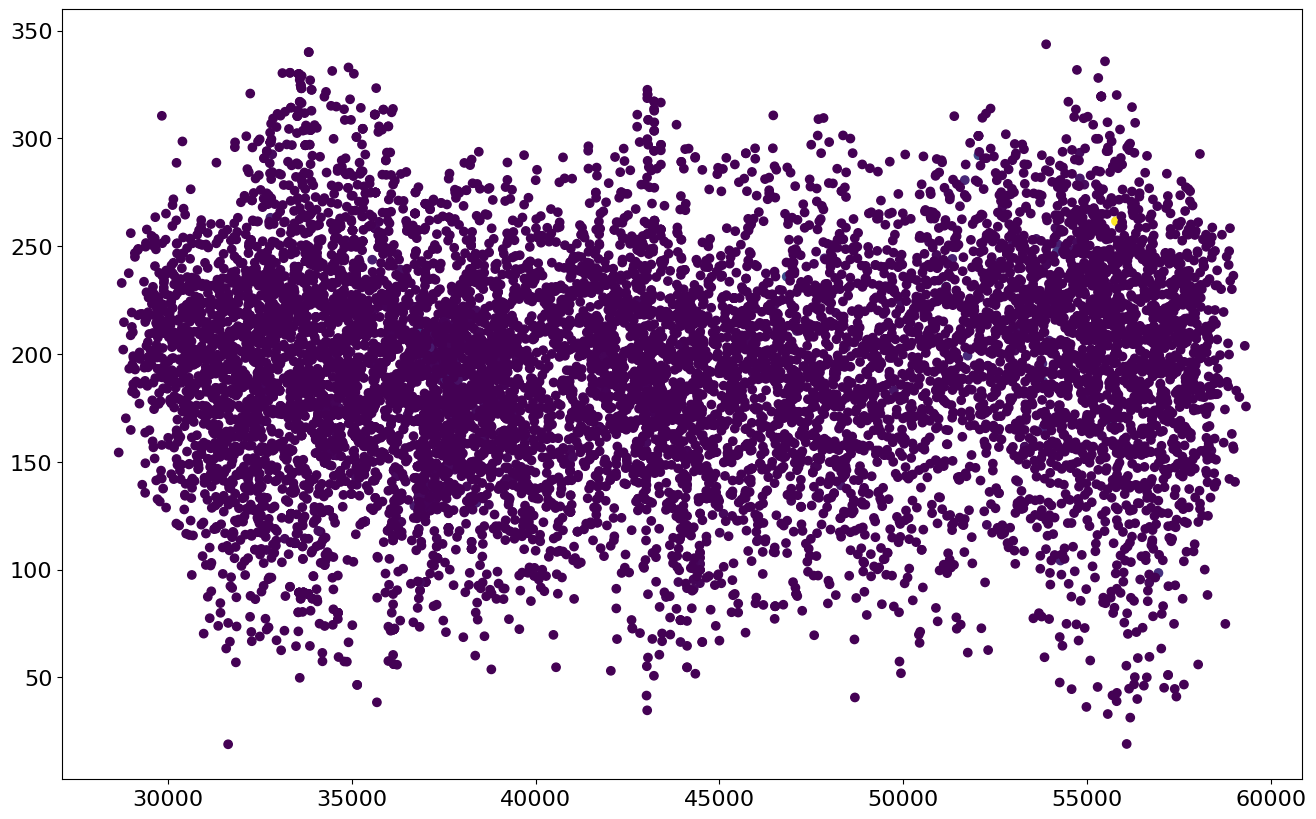

In [65]:
plt.scatter(df_combined['daylight_duration'], df_combined['wind_direction_10m_dominant'], c=df_combined['area_ha'])